##Importing Libraries 

In [ ]:
# Importing Required Libaries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

!pip install pmdarima
!pip install prophet

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from prophet import Prophet as proph
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

import warnings 
warnings.filterwarnings("ignore")

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Zillow Home Price Data for Cities in US
For this project, we are using the home price data for cities available on Zillow's website.

In [ ]:
zillow_city = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/zillow_city_data.csv')  ## Rivana's path
# zillow_city = pd.read_csv('/content/drive/MyDrive/DS_5500_Phase_2/zillow_city_data.csv') ##Pratik's Path

In [ ]:
zillow_city.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,130287.519134,130986.454069,...,624591.374167,632503.861776,639719.068154,644183.951334,645330.342375,642250.704367,639868.002388,636974.535334,632470.800784,629516.303341
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,205857.114461,206148.139291,...,899748.915585,908394.728386,913205.457773,915884.082386,913542.541439,909121.015865,904309.731512,901908.970409,898585.043168,890194.164509
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,95018.228813,94992.795115,...,247356.386226,251261.832612,254553.486054,256833.443059,257899.901884,258099.225384,258069.554808,258056.821868,257327.171539,255921.337783
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,120726.865760,120760.601509,...,285561.872355,286410.068889,286004.342441,284177.554780,281938.192950,279279.406615,277176.870186,276207.507874,275203.052968,276299.085040
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,94902.736943,94991.755467,...,250469.248807,254742.935336,258344.545768,260608.054991,261427.814664,261084.425131,260555.370376,260019.474525,258902.543330,257774.984016


##Exploratory Data Analysis
In this section, we explore the data further and create new columns to extract top states and cities with the highest return on investment after 10 years from 2013.

In [ ]:
zillow_city.isna().sum()

RegionID         0
SizeRank         0
RegionName       0
RegionType       0
StateName        0
              ... 
2022-09-30    1029
2022-10-31    1030
2022-11-30    1030
2022-12-31    1032
2023-01-31      18
Length: 285, dtype: int64

In [ ]:
zillow_city.isna().sum().sum()

2114789

In [ ]:
# NaN values in 'Metro'
print(zillow_city.loc[:, 'Metro'].isna().sum())

# Filling missing metro names with city names
zillow_city.loc[:, 'Metro'].fillna(zillow_city.loc[:, 'RegionName'], inplace=True)

4847


Just like 'Metro' the house price values for the date columns would also have null values. So, we will handle them by backfilling the values for the date columns.

In [ ]:
# Backfilling price columns with NaN values
zillow_city = zillow_city.backfill(axis='columns')
zillow_city = zillow_city.set_index('RegionName')
zillow_city

,RegionID,SizeRank,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,...,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31
RegionName,,,,,,,,,,,,,,,,,,,,,
New York,6181,0,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,130287.519134,130986.454069,131695.981347,...,624591.374167,632503.861776,639719.068154,644183.951334,645330.342375,642250.704367,639868.002388,636974.535334,632470.800784,629516.303341
Los Angeles,12447,1,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,205857.114461,206148.139291,207040.037608,...,899748.915585,908394.728386,913205.457773,915884.082386,913542.541439,909121.015865,904309.731512,901908.970409,898585.043168,890194.164509
Houston,39051,2,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,95018.228813,94992.795115,94860.606489,...,247356.386226,251261.832612,254553.486054,256833.443059,257899.901884,258099.225384,258069.554808,258056.821868,257327.171539,255921.337783
Chicago,17426,3,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,120726.86576,120760.601509,121067.795032,...,285561.872355,286410.068889,286004.342441,284177.55478,281938.19295,279279.406615,277176.870186,276207.507874,275203.052968,276299.08504
San Antonio,6915,4,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,94902.736943,94991.755467,95059.915068,...,250469.248807,254742.935336,258344.545768,260608.054991,261427.814664,261084.425131,260555.370376,260019.474525,258902.54333,257774.984016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Medicine Park,22420,28439,city,OK,OK,"Lawton, OK",Comanche County,88715.923471,88715.923471,88715.923471,...,206252.409184,209531.056389,213603.944939,216869.259322,219089.93224,221761.795174,224581.11848,227447.689632,228455.474661,229593.401556
Maud,49589,28439,city,TX,TX,"Texarkana, TX-AR",Bowie County,105906.681376,105906.681376,105906.681376,...,105842.369574,106677.407769,108136.184451,109282.148435,109520.999887,108946.109172,108417.933168,107509.129316,106789.767945,108007.719159
Newcastle,12973,28439,city,NE,NE,"Sioux City, IA-NE-SD",Dixon County,78575.0221,78575.0221,78575.0221,...,81703.312341,81973.760987,83170.277296,84959.171346,86212.367333,87117.505325,87715.082938,88137.351046,88730.960534,89979.603905


Next, we will create 4 new columns to show the ROI after 5 and 10 years, the total price increase from start to end as well as the price increase since the inception of COVID.

In [ ]:
# Creating new columns
zillow_city['ROI_5years'] = (zillow_city['2023-01-31'] - zillow_city['2018-01-31']) / (zillow_city['2018-01-31'])
zillow_city['ROI_10years'] = (zillow_city['2023-01-31'] - zillow_city['2013-01-31']) / (zillow_city['2013-01-31'])
zillow_city['price_increase'] = (zillow_city['2023-01-31'] - zillow_city['2000-01-31']) / (zillow_city['2000-01-31'])
zillow_city['COVID_increase'] = (zillow_city['2023-01-31'] - zillow_city['2019-12-31']) / (zillow_city['2019-12-31'])

In [ ]:
# States by highest ROI after 10 years from Jan 2013 to Jan 2023
zillow_state_roi = zillow_city.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 
                                      'CountyName','Metro', 'ROI_5years', 'COVID_increase', 'price_increase'], axis=1)
state_ROI_df = zillow_state_roi.groupby('State').mean().sort_values('ROI_10years', ascending=False)
state_ROI_df

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,ROI_10years
State,,,,,,,,,,,,,,,,,,,,,
FL,139004.115432,139270.096680,139576.481356,140231.009232,140917.495334,141624.655290,142318.291807,142996.559056,143681.709629,144340.511820,...,453738.151871,463656.567507,469862.624465,472356.753837,471415.057776,470023.654919,469042.962365,467526.823968,465830.302764,1.767637
ID,183647.125491,183643.679464,183643.127307,183642.294431,183649.101751,183656.646393,183669.385571,183681.771654,183697.024287,183708.841352,...,426177.544419,431489.749422,432528.313755,430478.430135,426000.683485,421694.399028,417481.025400,412902.201869,408476.362951,1.541191
KS,67458.208464,67457.295636,67457.670415,67457.600119,67462.126219,67470.695451,67482.753436,67493.863667,67502.221309,67508.291248,...,150730.755866,152783.893213,154401.118829,155179.593515,155293.434412,155236.641755,155159.490451,154758.183241,154497.532345,1.499429
NV,178408.983212,178579.711938,178755.846259,179244.876721,179877.027958,180597.511296,181331.516240,181945.763270,182650.914823,183288.842111,...,443016.661401,447409.520421,447721.251238,444300.785611,438088.752647,432746.223119,428035.165694,423815.316374,419362.422245,1.366818
AZ,143095.440105,143209.734857,143364.967839,143702.341634,144115.931157,144519.914392,144909.968184,145299.236504,145732.517638,146191.250689,...,369787.575673,375876.860343,378878.162205,378659.133372,375463.238775,371872.659459,368302.197303,364687.863722,362281.888956,1.365760
CO,188456.073469,188787.463304,189130.933303,189938.494359,190855.601662,191899.704206,192971.108676,194161.184309,195406.372169,196666.424093,...,519934.879935,526238.987926,528208.013797,526471.850950,522312.876930,518988.888791,516328.575953,513268.479894,509987.036947,1.361141
WA,203898.719689,204065.977682,204261.785775,204661.946505,205106.850516,205525.511180,206053.134439,206589.474370,207126.741008,207558.332811,...,553283.447493,557044.328185,555549.100566,550468.516297,543770.812544,538855.278054,535632.012086,532530.175903,529518.582465,1.357688
CA,250611.659321,251177.451735,251963.662042,253727.819414,255846.243988,258212.732619,260814.894000,263601.423350,266448.315557,269085.527136,...,769777.062552,774832.835537,774120.355077,768286.014677,759558.825653,752394.421236,747149.066602,742186.235402,735056.910127,1.276984
OR,168171.552971,168316.943249,168474.872109,168799.181147,169151.913025,169471.923001,169744.768792,170018.372046,170306.336695,170627.301572,...,433071.339369,437659.544191,438828.822529,437006.232545,433260.510133,430350.171743,428215.523667,426164.243490,424183.553097,1.233438


Text(0, 0.5, 'Increase Rate')

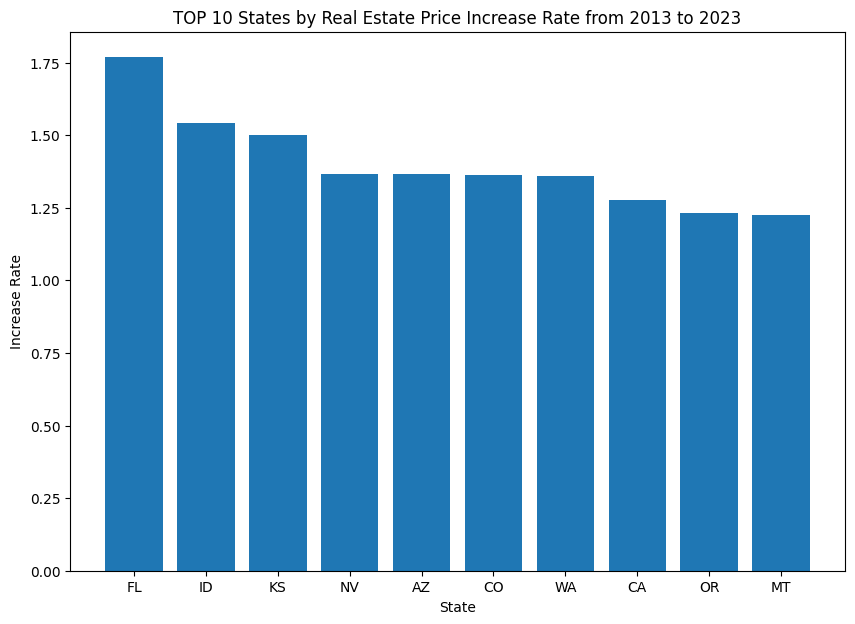

In [ ]:
# Visualizing the top 10 states with the highest ROI after 10 years
top10 = state_ROI_df.nlargest(10, 'ROI_10years')
plt.figure(figsize = (10, 7))
plt.bar(top10.index, top10['ROI_10years'])
plt.title('TOP 10 States by Real Estate Price Increase Rate from 2013 to 2023')
plt.xlabel('State')
plt.ylabel('Increase Rate')

In [ ]:
# Cities sorted by highest ROI after 10 years
zillow_city_roi = zillow_city.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 
                                      'CountyName','Metro', 'ROI_5years'], axis=1)
city_ROI_df = zillow_city_roi.groupby(['RegionName', 'State']).mean().sort_values('ROI_10years', ascending=False)
city_ROI_df

,,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,ROI_10years,price_increase,COVID_increase
RegionName,State,,,,,,,,,,,,,,,,,,,,,
Stanardsville,VA,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,4512.116630,...,275833.003416,277303.843342,277503.961970,277648.201446,276778.655047,275110.534347,274065.141726,70.046957,59.739818,0.331712
Dyke,VA,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,13504.901553,...,359269.652723,361621.856880,361832.617996,361500.235847,360187.118717,358146.587884,356682.028557,33.681949,25.411302,0.363161
New Concord,KY,3243.672420,3240.064173,3233.231590,3226.388258,3215.604996,3200.860103,3202.918650,3226.636789,3280.469080,3331.858151,...,131677.879599,138980.589678,145306.652422,150519.287973,155034.456774,155796.549537,157870.504929,23.945802,47.670298,3.658873
Free Union,VA,22247.933280,22298.489858,22418.748929,22672.417680,22970.896906,23208.841011,23448.130906,23758.093891,24043.689710,24310.982548,...,500779.754753,504172.337920,504758.315725,504873.904914,503929.094681,500798.240067,498481.310661,14.472588,21.405736,0.371095
Guilford,MO,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,15970.196775,...,194020.416474,193458.565208,191150.653068,189953.221822,191303.305838,193790.819487,190474.568157,10.302473,10.926877,1.468657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Repton,AL,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,...,131096.348337,131026.080317,129528.251369,128672.793599,128179.873659,128849.486729,NaN,NaN,NaN,NaN
Santa Rosa,TX,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,...,110473.101574,108826.332794,106543.415120,105798.742949,105979.854541,106333.112128,NaN,NaN,NaN,NaN
Taylorsville,NC,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,...,214566.190762,214816.168426,213609.044643,212294.660666,212031.109592,212788.503371,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Increase Rate')

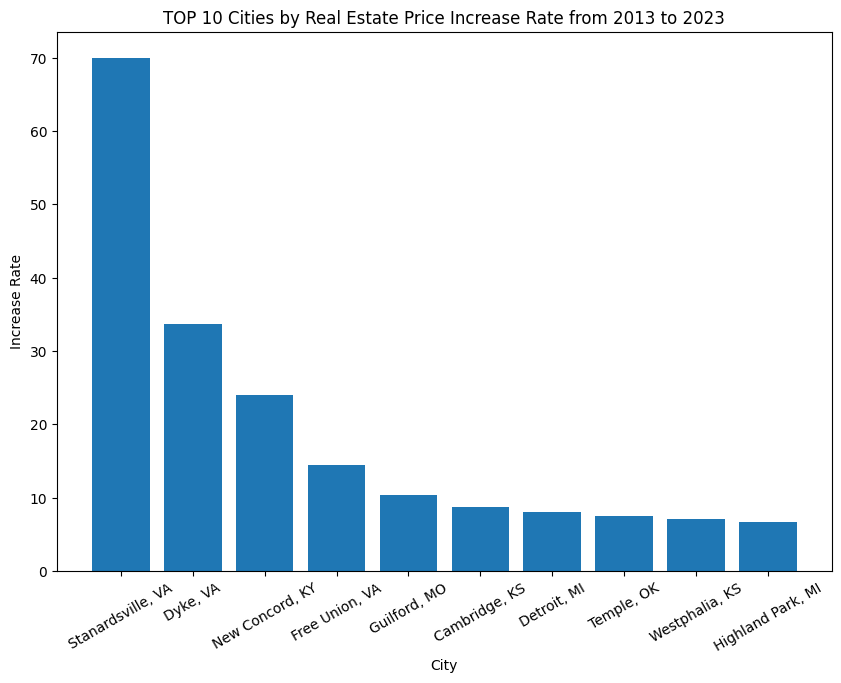

In [ ]:
# Visualizing the top 10 cities with highest 10 year ROI
top10_cities = city_ROI_df.nlargest(10, 'ROI_10years')

temp_list = []
for i in range(len(top10_cities.index)):
  temp_list.append(top10_cities.index[i][0] + ', ' + top10_cities.index[i][1])
top10_cities['city_names'] = temp_list

plt.figure(figsize = (10, 7))
plt.bar(top10_cities['city_names'], top10_cities['ROI_10years'])
plt.title('TOP 10 Cities by Real Estate Price Increase Rate from 2013 to 2023')
plt.xlabel('City')
plt.xticks(rotation=30)
plt.ylabel('Increase Rate')

In [ ]:
# Top cities with the highest price increase in COVID years
zillow_COVID_roi = zillow_city.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 
                                      'CountyName','Metro', 'ROI_5years'], axis=1)
COVID_ROI_df = zillow_COVID_roi.groupby(['RegionName', 'State']).mean().sort_values('COVID_increase', ascending=False)
COVID_ROI_df

,,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,ROI_10years,price_increase,COVID_increase
RegionName,State,,,,,,,,,,,,,,,,,,,,,
Longford,KS,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,19312.877956,...,133446.127467,134640.084902,134996.320769,135077.196365,134932.314283,134384.726448,133153.199149,5.894529,5.894529,4.053667
Paradise,KS,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,23953.851967,...,133515.924958,136061.459843,137005.373052,137425.634394,137324.437125,136687.764009,129131.027795,4.390825,4.390825,4.047802
Cambridge,KS,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,14522.628923,...,149244.630400,151082.515659,151165.024642,150544.957382,149916.953701,149223.132046,145522.777950,8.664198,9.020416,3.930871
New Concord,KY,3243.672420,3240.064173,3233.231590,3226.388258,3215.604996,3200.860103,3202.918650,3226.636789,3280.469080,3331.858151,...,131677.879599,138980.589678,145306.652422,150519.287973,155034.456774,155796.549537,157870.504929,23.945802,47.670298,3.658873
Westphalia,KS,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,21986.557683,...,174707.303746,176529.660056,177137.103210,176978.959558,176444.346517,175562.149569,173612.015184,7.144555,6.896280,3.416054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Repton,AL,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,101803.009728,...,131096.348337,131026.080317,129528.251369,128672.793599,128179.873659,128849.486729,NaN,NaN,NaN,NaN
Santa Rosa,TX,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,53047.184542,...,110473.101574,108826.332794,106543.415120,105798.742949,105979.854541,106333.112128,NaN,NaN,NaN,NaN
Taylorsville,NC,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,119863.247865,...,214566.190762,214816.168426,213609.044643,212294.660666,212031.109592,212788.503371,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Increase Rate')

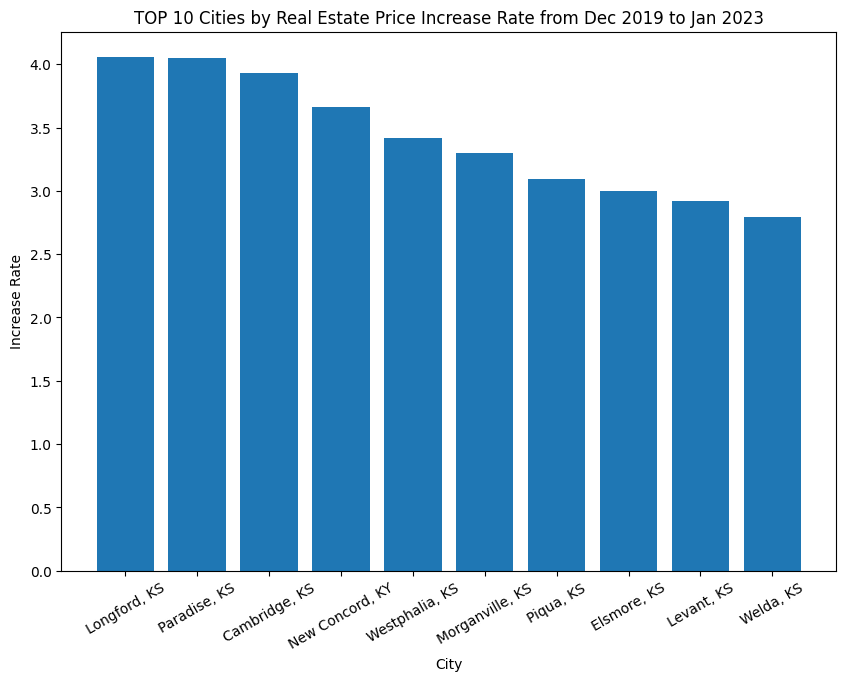

In [ ]:
# Visualizing the top 10 cities with highest increase in COVID years
COVID_top10 = COVID_ROI_df.nlargest(10, 'COVID_increase')

temp_list = []
for i in range(len(COVID_top10.index)):
  temp_list.append(COVID_top10.index[i][0] + ', ' + COVID_top10.index[i][1])

COVID_top10['city_names'] = temp_list

plt.figure(figsize = (10, 7))
plt.bar(COVID_top10['city_names'], COVID_top10['COVID_increase'])
plt.title('TOP 10 Cities by Real Estate Price Increase Rate from Dec 2019 to Jan 2023')
plt.xlabel('City')
plt.xticks(rotation=30)
plt.ylabel('Increase Rate')

##Selecting a subset of the dataset for Time Series Analysis
The Zillow dataset consists details of a lot of cities across the country. To further perform time series analysis on the data, we will be selecting 6 cities of interest - New York, Los Angeles, San Francisco, Washington DC, Austin and Seattle.


In [ ]:
# Subsetting the dataframe
cities_df = zillow_city[((zillow_city.index == 'New York') & (zillow_city['State'] == 'NY')) |
                        ((zillow_city.index == 'Los Angeles') & (zillow_city['State'] == 'CA')) |
                        ((zillow_city.index == 'San Francisco') & (zillow_city['State'] == 'CA')) |
                        ((zillow_city.index == 'Washington') & (zillow_city['State'] == 'DC')) |
                        ((zillow_city.index == 'Austin') & (zillow_city['State'] == 'TX')) |
                        ((zillow_city.index == 'Seattle') & (zillow_city['State'] == 'WA'))]
cities_df

,RegionID,SizeRank,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,...,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,ROI_5years,ROI_10years,price_increase,COVID_increase
RegionName,,,,,,,,,,,,,,,,,,,,,
New York,6181,0,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,130287.519134,130986.454069,131695.981347,...,645330.342375,642250.704367,639868.002388,636974.535334,632470.800784,629516.303341,0.392538,1.468609,3.831747,0.177045
Los Angeles,12447,1,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,205857.114461,206148.139291,207040.037608,...,913542.541439,909121.015865,904309.731512,901908.970409,898585.043168,890194.164509,0.569095,1.373509,3.32433,0.305916
Austin,10221,10,city,TX,TX,"Austin-Round Rock-Georgetown, TX",Travis County,181010.892589,181717.346225,182383.337418,...,595188.596984,587057.235665,579506.557996,572409.819088,564802.439979,557909.704844,0.614553,1.525606,2.082189,0.47639
San Francisco,20330,14,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",San Francisco County,388521.878329,390500.562075,393215.153069,...,1407858.970209,1373480.723097,1344030.339896,1320302.316046,1300246.903536,1287792.135931,0.063377,0.833624,2.314594,-0.004194
Seattle,16037,21,city,WA,WA,"Seattle-Tacoma-Bellevue, WA",King County,258561.719217,259804.45214,261096.704771,...,871456.919523,855226.214771,844022.16916,837852.054179,833927.882916,831101.86098,0.209456,1.173441,2.214327,0.180889
Washington,41568,25,city,DC,DC,"Washington-Arlington-Alexandria, DC-VA-MD-WV",District of Columbia,146896.463022,147380.496054,148048.68133,...,640856.454177,632998.477967,627366.835822,623083.165823,619359.104225,615691.991679,0.195222,0.720395,3.191333,0.101695


In [ ]:
# Sorting the dataframe by decreasing 10 year ROI
zillow_subset_roi = cities_df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 
                                      'CountyName','Metro', 'ROI_5years', 'price_increase', 'COVID_increase'], axis=1)
ROI_df = zillow_subset_roi.groupby('RegionName').mean().sort_values('ROI_10years', ascending=False)
ROI_df

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,ROI_10years
RegionName,,,,,,,,,,,,,,,,,,,,,
Austin,181010.892589,181717.346225,182383.337418,183371.857647,184062.705257,184250.425169,184371.464552,185158.423677,186042.336762,187260.424091,...,5.920532e+05,5.997480e+05,6.001982e+05,5.951886e+05,5.870572e+05,5.795066e+05,5.724098e+05,5.648024e+05,5.579097e+05,1.525606
New York,130287.519134,130986.454069,131695.981347,133068.080275,134445.248650,135927.964028,137481.690711,138929.938136,140270.198550,141745.926410,...,6.325039e+05,6.397191e+05,6.441840e+05,6.453303e+05,6.422507e+05,6.398680e+05,6.369745e+05,6.324708e+05,6.295163e+05,1.468609
Los Angeles,205857.114461,206148.139291,207040.037608,208814.686358,211046.178463,213210.289862,215431.355540,217742.077768,219917.649616,221698.439211,...,9.083947e+05,9.132055e+05,9.158841e+05,9.135425e+05,9.091210e+05,9.043097e+05,9.019090e+05,8.985850e+05,8.901942e+05,1.373509
Seattle,258561.719217,259804.452140,261096.704771,263695.116480,266593.396739,269250.965106,272135.142205,274460.923039,276502.982787,278013.305753,...,8.939842e+05,8.950240e+05,8.863705e+05,8.714569e+05,8.552262e+05,8.440222e+05,8.378521e+05,8.339279e+05,8.311019e+05,1.173441
San Francisco,388521.878329,390500.562075,393215.153069,399073.492924,405951.624629,413544.411061,421566.100279,429946.762786,438312.817532,446866.465768,...,1.466334e+06,1.458106e+06,1.438211e+06,1.407859e+06,1.373481e+06,1.344030e+06,1.320302e+06,1.300247e+06,1.287792e+06,0.833624
Washington,146896.463022,147380.496054,148048.681330,149493.215736,151094.607659,152837.638631,154499.292254,155931.901867,157004.712039,157280.152549,...,6.508490e+05,6.508791e+05,6.470987e+05,6.408565e+05,6.329985e+05,6.273668e+05,6.230832e+05,6.193591e+05,6.156920e+05,0.720395


Now, once we have performed EDA and feature engineering, we will convert the dataframe into a time series for further analysis.

In [ ]:
# Function to drop non-date time columns
def drop_columns(df):
  for col in df.columns:
    if col in ('RegionID', 'RegionType', 'CountyName', 'Metro', 'SizeRank',
                'State', 'increase', 'increase_rate', 'StateName', 'ROI_5years', 
                'ROI_10years', 'price_increase', 'COVID_increase'):
        df = df.drop(col, axis=1)
  return df

In [ ]:
# Function to convert columns to datetime
def convert_datetime(df):
  df = pd.to_datetime(df.columns.values[:], format='%Y-%m-%d', exact=True)
  df = df.T 
  return df

In [ ]:
cities_df.columns

Index(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'Metro',
       'CountyName', '2000-01-31', '2000-02-29', '2000-03-31',
       ...
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
       '2023-01-31', 'ROI_5years', 'ROI_10years', 'price_increase',
       'COVID_increase'],
      dtype='object', length=288)

In [ ]:
# Creating a new dataframe using the datetime columns only
zillow_date_df = drop_columns(cities_df)
zillow_date_df.columns = list(convert_datetime(zillow_date_df))
zillow_date_df

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31
RegionName,,,,,,,,,,,,,,,,,,,,,
New York,130287.519134,130986.454069,131695.981347,133068.080275,134445.24865,135927.964028,137481.690711,138929.938136,140270.19855,141745.92641,...,624591.374167,632503.861776,639719.068154,644183.951334,645330.342375,642250.704367,639868.002388,636974.535334,632470.800784,629516.303341
Los Angeles,205857.114461,206148.139291,207040.037608,208814.686358,211046.178463,213210.289862,215431.35554,217742.077768,219917.649616,221698.439211,...,899748.915585,908394.728386,913205.457773,915884.082386,913542.541439,909121.015865,904309.731512,901908.970409,898585.043168,890194.164509
Austin,181010.892589,181717.346225,182383.337418,183371.857647,184062.705257,184250.425169,184371.464552,185158.423677,186042.336762,187260.424091,...,578562.821981,592053.208547,599748.032359,600198.182314,595188.596984,587057.235665,579506.557996,572409.819088,564802.439979,557909.704844
San Francisco,388521.878329,390500.562075,393215.153069,399073.492924,405951.624629,413544.411061,421566.100279,429946.762786,438312.817532,446866.465768,...,1461817.236819,1466333.860309,1458105.594852,1438211.315764,1407858.970209,1373480.723097,1344030.339896,1320302.316046,1300246.903536,1287792.135931
Seattle,258561.719217,259804.45214,261096.704771,263695.11648,266593.396739,269250.965106,272135.142205,274460.923039,276502.982787,278013.305753,...,883761.787023,893984.169055,895024.043923,886370.539785,871456.919523,855226.214771,844022.16916,837852.054179,833927.882916,831101.86098
Washington,146896.463022,147380.496054,148048.68133,149493.215736,151094.607659,152837.638631,154499.292254,155931.901867,157004.712039,157280.152549,...,646657.14932,650849.011352,650879.069606,647098.737016,640856.454177,632998.477967,627366.835822,623083.165823,619359.104225,615691.991679


In [ ]:
zillow_cities_df = cities_df.drop(['RegionID', 'RegionType', 'CountyName', 'Metro', 'SizeRank', 
                                   'State', 'StateName', 'ROI_5years', 'price_increase', 'COVID_increase'], axis=1)

Text(0, 0.5, 'Rate of ROI')

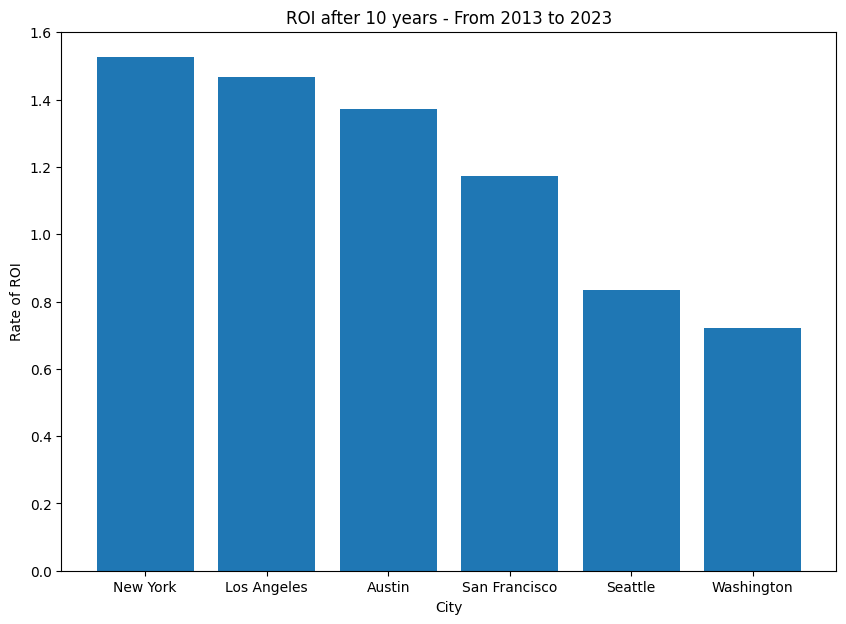

In [ ]:
# Visualizing 10 year ROI for the selected cities
plt.figure(figsize = (10, 7))
plt.bar(zillow_cities_df.index, zillow_cities_df.sort_values('ROI_10years', ascending=False)['ROI_10years'])
plt.title('ROI after 10 years - From 2013 to 2023')
plt.xlabel('City')
plt.ylabel('Rate of ROI')

In [ ]:
# Concatenating the time series dataframe with the 10 year ROI column
zillow_top_df = pd.concat([cities_df['ROI_10years'], zillow_date_df], axis=1)
zillow_top_df.head()

,ROI_10years,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,...,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,2023-01-31 00:00:00
RegionName,,,,,,,,,,,,,,,,,,,,,
New York,1.468609,130287.519134,130986.454069,131695.981347,133068.080275,134445.24865,135927.964028,137481.690711,138929.938136,140270.19855,...,624591.374167,632503.861776,639719.068154,644183.951334,645330.342375,642250.704367,639868.002388,636974.535334,632470.800784,629516.303341
Los Angeles,1.373509,205857.114461,206148.139291,207040.037608,208814.686358,211046.178463,213210.289862,215431.35554,217742.077768,219917.649616,...,899748.915585,908394.728386,913205.457773,915884.082386,913542.541439,909121.015865,904309.731512,901908.970409,898585.043168,890194.164509
Austin,1.525606,181010.892589,181717.346225,182383.337418,183371.857647,184062.705257,184250.425169,184371.464552,185158.423677,186042.336762,...,578562.821981,592053.208547,599748.032359,600198.182314,595188.596984,587057.235665,579506.557996,572409.819088,564802.439979,557909.704844
San Francisco,0.833624,388521.878329,390500.562075,393215.153069,399073.492924,405951.624629,413544.411061,421566.100279,429946.762786,438312.817532,...,1461817.236819,1466333.860309,1458105.594852,1438211.315764,1407858.970209,1373480.723097,1344030.339896,1320302.316046,1300246.903536,1287792.135931
Seattle,1.173441,258561.719217,259804.45214,261096.704771,263695.11648,266593.396739,269250.965106,272135.142205,274460.923039,276502.982787,...,883761.787023,893984.169055,895024.043923,886370.539785,871456.919523,855226.214771,844022.16916,837852.054179,833927.882916,831101.86098


In [ ]:
# Manipulating the time series dataframe for visualization
time_series = zillow_date_df.T
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.astype(float)
time_series.head()

RegionName,New York,Los Angeles,Austin,San Francisco,Seattle,Washington
2000-01-31,130287.519134,205857.114461,181010.892589,388521.878329,258561.719217,146896.463022
2000-02-29,130986.454069,206148.139291,181717.346225,390500.562075,259804.452140,147380.496054
2000-03-31,131695.981347,207040.037608,182383.337418,393215.153069,261096.704771,148048.681330
2000-04-30,133068.080275,208814.686358,183371.857647,399073.492924,263695.116480,149493.215736
2000-05-31,134445.248650,211046.178463,184062.705257,405951.624629,266593.396739,151094.607659


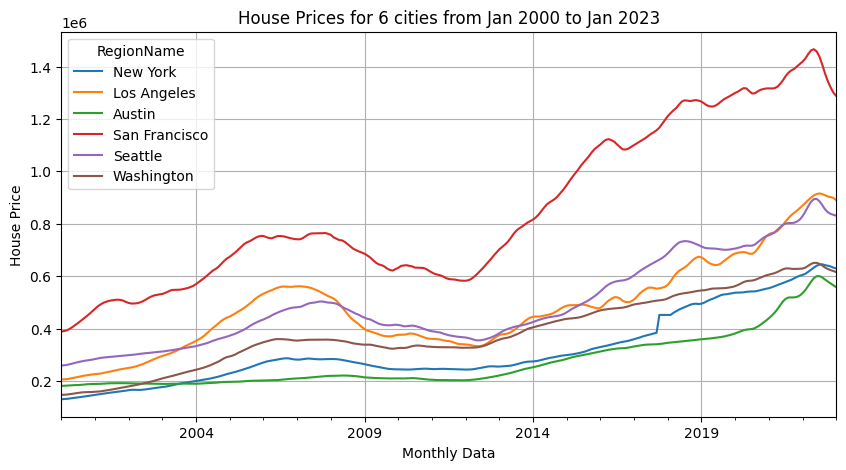

In [ ]:
# Visualizing the trends in home prices for the selected cities
ax = time_series.plot(figsize = (10,5), subplots=False, legend=True, grid=True,
                  xlabel='Monthly Data', ylabel='House Price', 
                  title='House Prices for 6 cities from Jan 2000 to Jan 2023')
plt.show()

In [ ]:
# Function to melt the time series data
def melt_data(df):
  melt_df = pd.melt(df, id_vars=['ROI_10years'], var_name='time')
  melt_df['time'] = pd.to_datetime(melt_df['time'], infer_datetime_format=True)
  melt_df = melt_df.dropna(subset=['value'])
  melt_df.drop(['ROI_10years'], axis=1, inplace=True)
  melt_df.value = melt_df.value.astype('int')
  melt_df = melt_df.groupby('time').aggregate({'value':'mean'})
  return melt_df

In [ ]:
# Function to get the melted time series df for a given city
def melted_city_df(df, city_name):
  city = df.loc[city_name, :]
  melted_df = melt_data(city.to_frame().T)
  return melted_df

In [ ]:
# Function to plot the house price trends for a given city
def plot_city_time_series(df):
  plt.figure(figsize=(10, 7))
  plt.grid()
  plt.plot(df.index, df.value)

##ARIMA Modeling and Evaluation
Here, we will perform ARIMA modeling on the time series data and plot the forecasted results. Finally, we will also evaluate the predicts of the model using Root Mean Squared Error (RMSE).

In [ ]:
# Function to plot the time series and forecasted series
def plot_forecast(city_df, forecast_series, city_name):
  fig, ax = plt.subplots(figsize=(12, 7))
  plt.plot(city_df)
  plt.plot(forecast_series['mean'])
  ax.fill_between(forecast_series.index, forecast_series['mean_ci_lower'], 
                      forecast_series['mean_ci_upper'], color='k', alpha=0.1)
  plt.title(city_name)
  plt.legend(['Original','Predicted'], loc='lower right')
  plt.xlabel('Year')
  plt.ylabel('Median Home Price')
  plt.show()

In [ ]:
# This function will perform ARIMA modeling on the dataset, plot the forecasted
# values and calculated the RMSE for model evaluation
def get_forecast_ARIMA(top_df, city_name):
  city = melted_city_df(top_df, city_name)  
  train = city['2013-01-01':'2020-12-31']
  test = city['2020-12-31':]

  transformed_data = train
  gridsearch = auto_arima(transformed_data, start_p=1, start_q=1, test='adf',
                         max_p=3, max_q=3, m=12, start_P=0, seasonal=False,
                         d=None, D=1, trace=True, error_action='ignore',  
                         suppress_warnings=True, stepwise=True)
  model = ARIMA(transformed_data, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)  
  model_1 = model.fit()

  log_forecast = model_1.get_forecast(len(test))
  forecast_series = log_forecast

  forecast_series = forecast_series.summary_frame()
  
  # Calculating RMSE for model evaluation
  rmse = np.sqrt(mean_squared_error(list(test.iloc[:, 0]), list(forecast_series['mean'])))
  print("City Name: ", city_name)
  print(f'Test RMSE: {rmse:.3f}\n')

  # Plotting the predicted and actual values
  plot_forecast(city, forecast_series, city_name)
  return rmse

Now, we will generate the predictions for house prices for the selected 6 cities of interest.

In [ ]:
#Creating a list to store rmse values
arima_rmse_values = []

###New York

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1956.481, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1952.540, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1954.400, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1954.472, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1968.371, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.467 seconds
City Name:  New York
Test RMSE: 59621.017



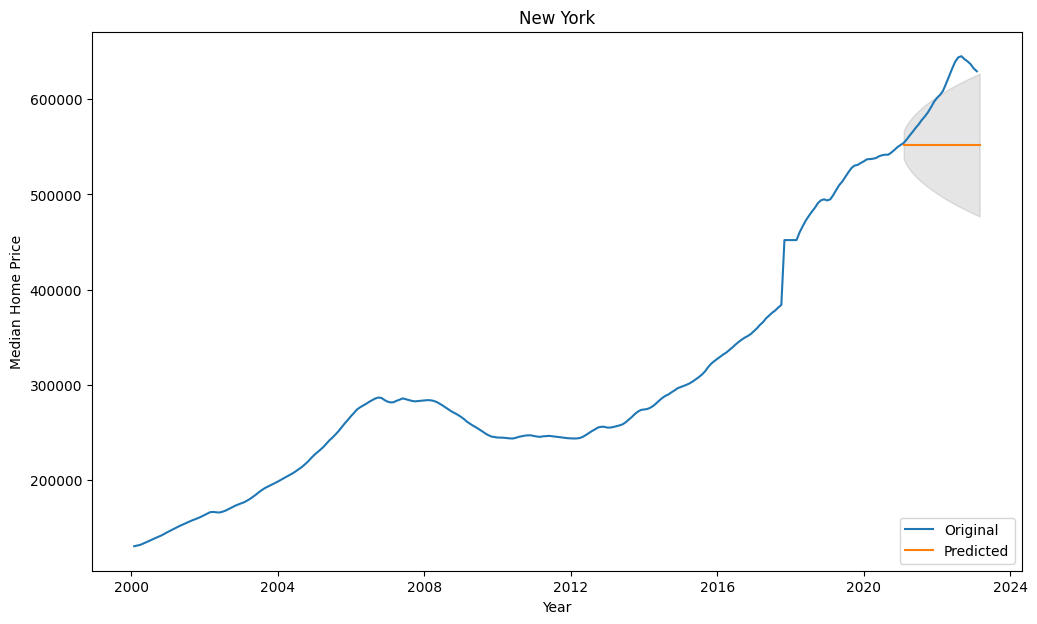

In [ ]:
# Getting forecast for city of New York 
ny_rmse = get_forecast_ARIMA(zillow_top_df, 'New York')
arima_rmse_values.append(ny_rmse)

###Los Angeles

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1918.117, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1914.393, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2198.296, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1916.778, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1950.643, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.730 seconds
City Name:  Los Angeles
Test RMSE: 113557.754



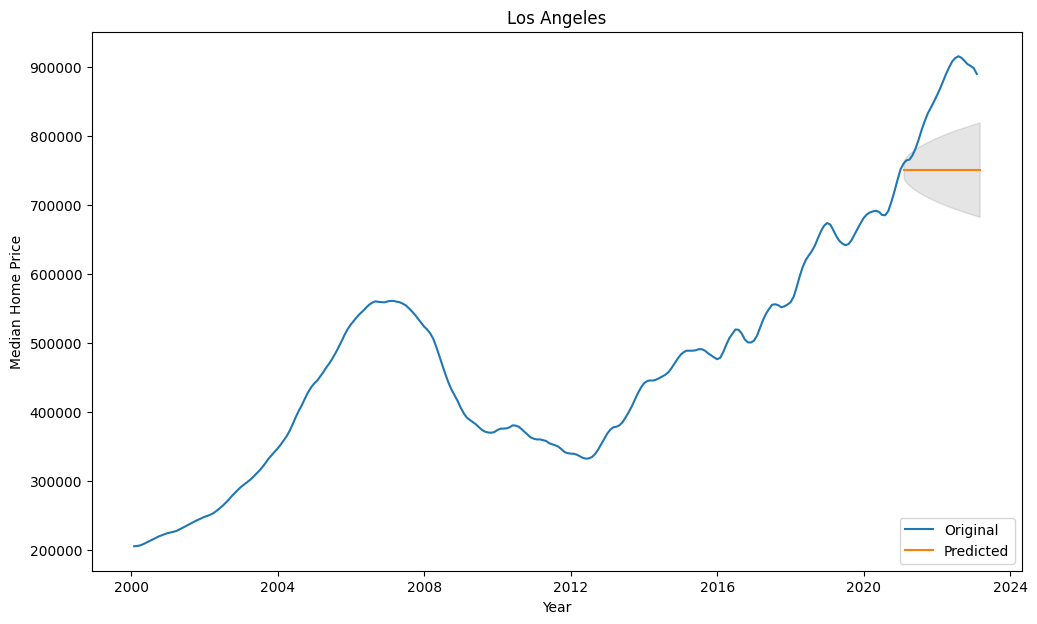

In [ ]:
#Getting forecast for city of Los Angeles
la_rmse = get_forecast_ARIMA(zillow_top_df, 'Los Angeles')
arima_rmse_values.append(la_rmse)

###San Francisco

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.432, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1944.209, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2466.833, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1947.553, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2006.309, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1936.159, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1941.229, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1971.731, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1974.986, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1930.574, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.500 seconds
City Name:  San Francisco
Test RMSE: 69337.111



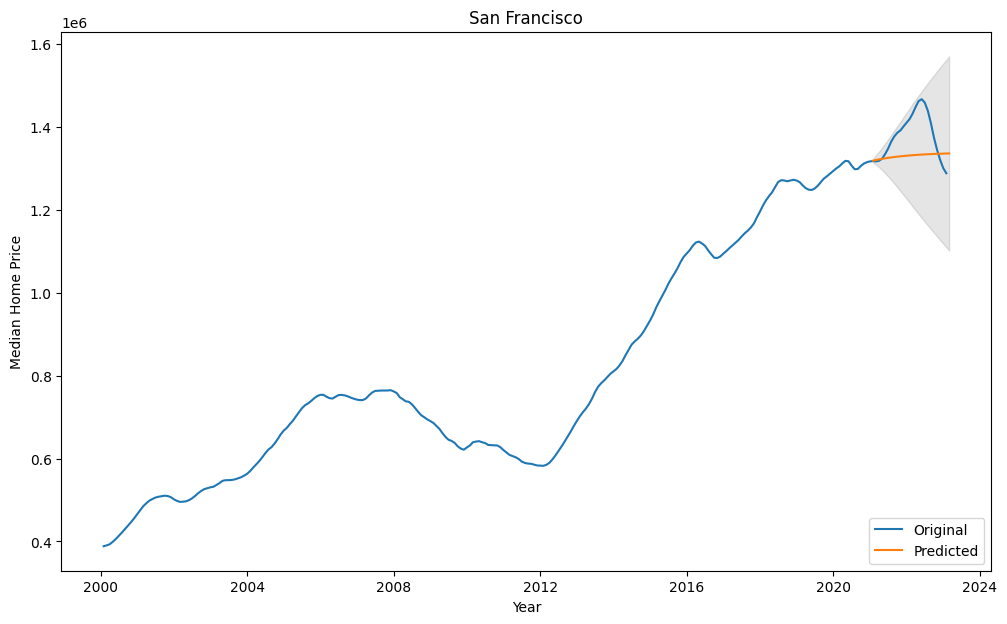

In [ ]:
# Getting forecast for the city of San Francisco
sf_rmse = get_forecast_ARIMA(zillow_top_df, 'San Francisco')
arima_rmse_values.append(sf_rmse)

###Washington DC

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1725.435, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2790.504, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2725.659, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2714.035, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1740.863, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.125 seconds
City Name:  Washington
Test RMSE: 32438.988



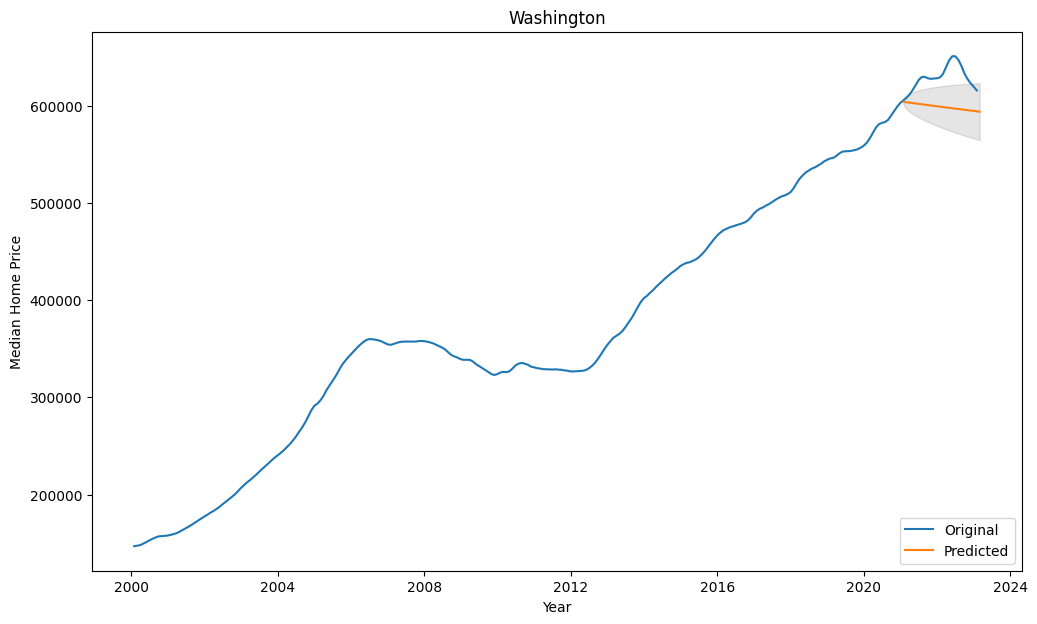

In [ ]:
# Getting forecast for the city of Washington DC
w_rmse = get_forecast_ARIMA(zillow_top_df, 'Washington')
arima_rmse_values.append(w_rmse)

###Austin

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1446.877, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1448.371, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1448.281, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1446.205, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.371 seconds
City Name:  Austin
Test RMSE: 26993.172



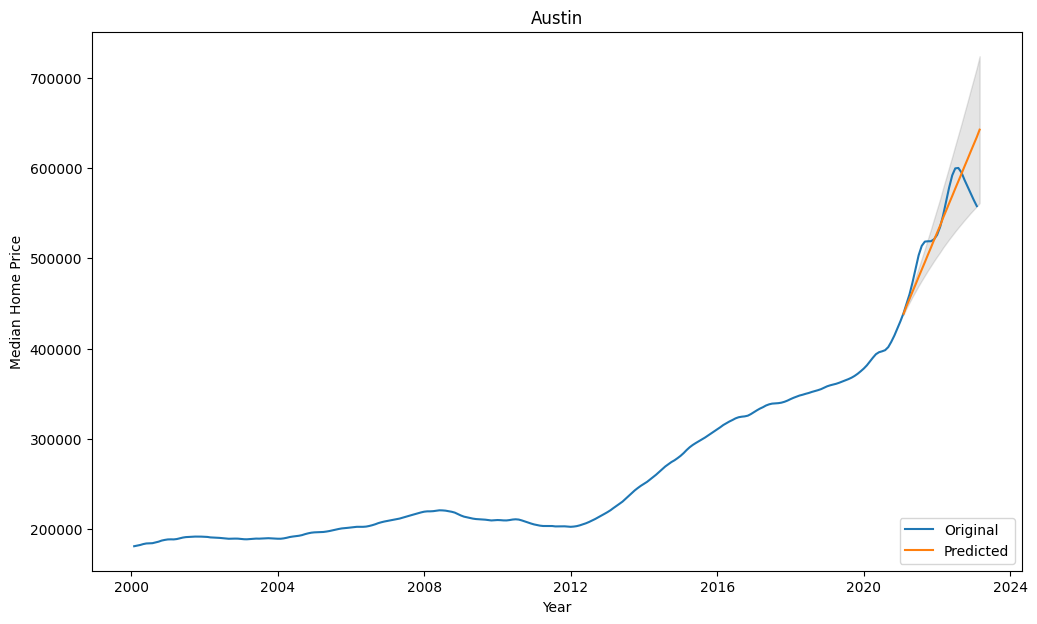

In [ ]:
# Getting forecast for the city of Austin
a_rmse = get_forecast_ARIMA(zillow_top_df, 'Austin')
arima_rmse_values.append(a_rmse)

###Seattle

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1626.292, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1624.881, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1633.917, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1628.212, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1622.883, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.337 seconds
City Name:  Seattle
Test RMSE: 27052.300



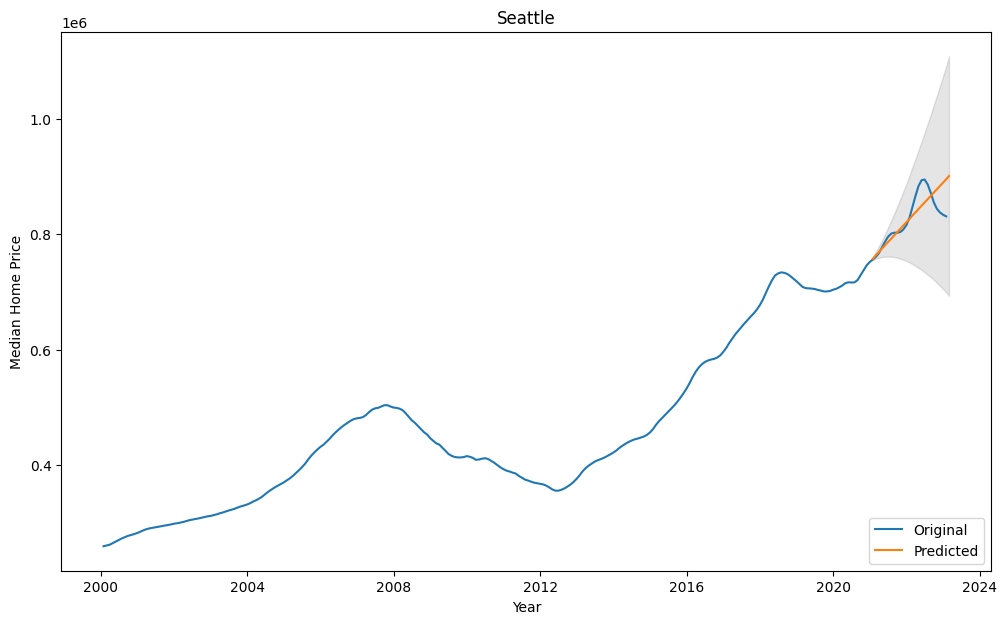

In [ ]:
# Getting forecast for the city of Seattle
s_rmse = get_forecast_ARIMA(zillow_top_df, 'Seattle')
arima_rmse_values.append(s_rmse)

As we can see from the time series plots for these cities, there is a sharp decline in house prices starting from July 2022. This is because of the increase in the interest rates by banks as well as the increase in the rate of construction materials. This is causing a major housing market correction which the model would be able to predict. Hence, there is a gap between actual and predicted values.

##SARIMAX Modelling and Evaluation

Here, we will perform Prophet modeling on the time series data and plot the forecasted results. Finally, we will also evaluate the predicts of the model using Root Mean Squared Error (RMSE).

In [ ]:
def plot_forecast_sarima(df,fitted_series,city_name):
  
  #Plot
  plt.figure(figsize=(15,7))
  plt.plot(df['value'])
  plt.plot(fitted_series)
  #   # plt.fill_between(lower_series.index, 
  #   #                 lower_series, 
  #   #                 upper_series, 
  #   #                 color='k', alpha=.15)

  plt.title(city_name)
  plt.show()

In [ ]:
def get_forecast_SARIMAX(top_df, city_name):
  city = melted_city_df(top_df, city_name)  
  train = city['2013-01-01':'2020-12-31']
  test = city['2020-12-31':]

  transformed_data = train

  transformed_data['month_index'] = transformed_data.index.month

  
  SARIMAX_model  = auto_arima(list(transformed_data['value']), exogenous=transformed_data[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
  
  fitted, confint = SARIMAX_model.predict(n_periods=len(test), 
                                           return_conf_int=True,
                                           exogenous=transformed_data[['month_index']]) 
  
  
  fitted_series = pd.Series(fitted, index=test.index)

  #Calculating RMSE values
  rmse = np.sqrt(mean_squared_error(list(test.iloc[:, 0]), list(fitted_series)))
  print("City Name: ", city_name)
  print(f'Test RMSE: {rmse:.3f}\n')
  
  #Calling Plot Function for SARIMAX values
  plot_forecast_sarima(city, fitted_series, city_name)


  return rmse
  

In [ ]:
#Creating a list for RMSE scores of SARIMAX
sarimax_rmse_values = []

###New York

City Name:  New York
Test RMSE: 34689.949



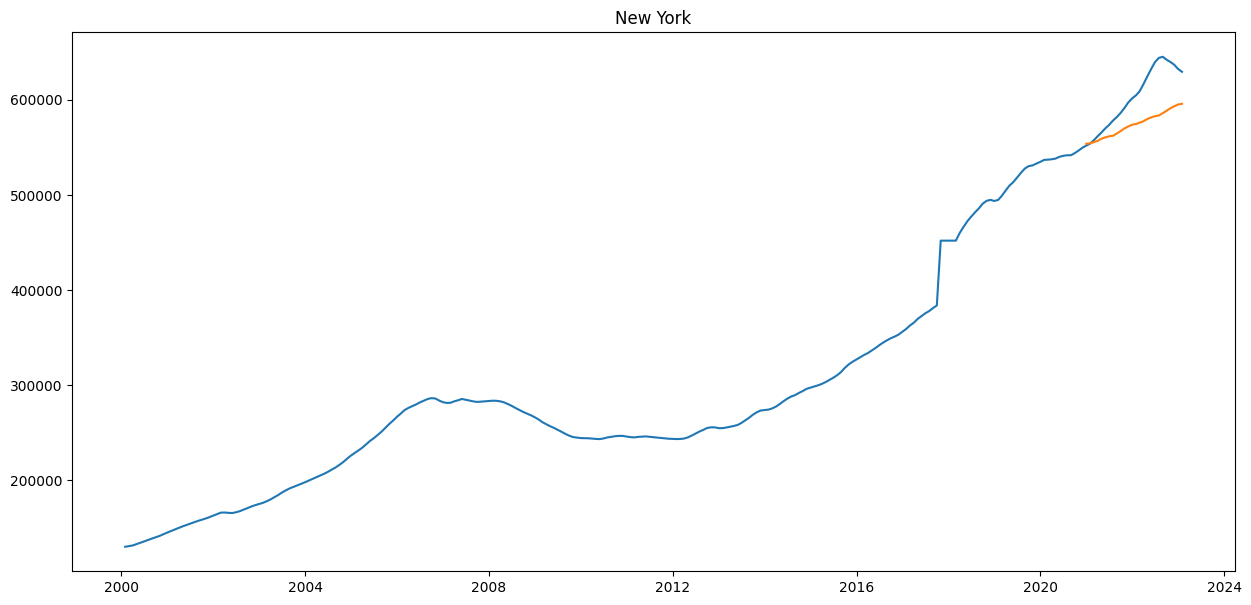

In [ ]:
ny_rmse = get_forecast_SARIMAX(zillow_cities_df,'New York')
sarimax_rmse_values.append(ny_rmse)

###Los Angeles

City Name:  Los Angeles
Test RMSE: 142150.661



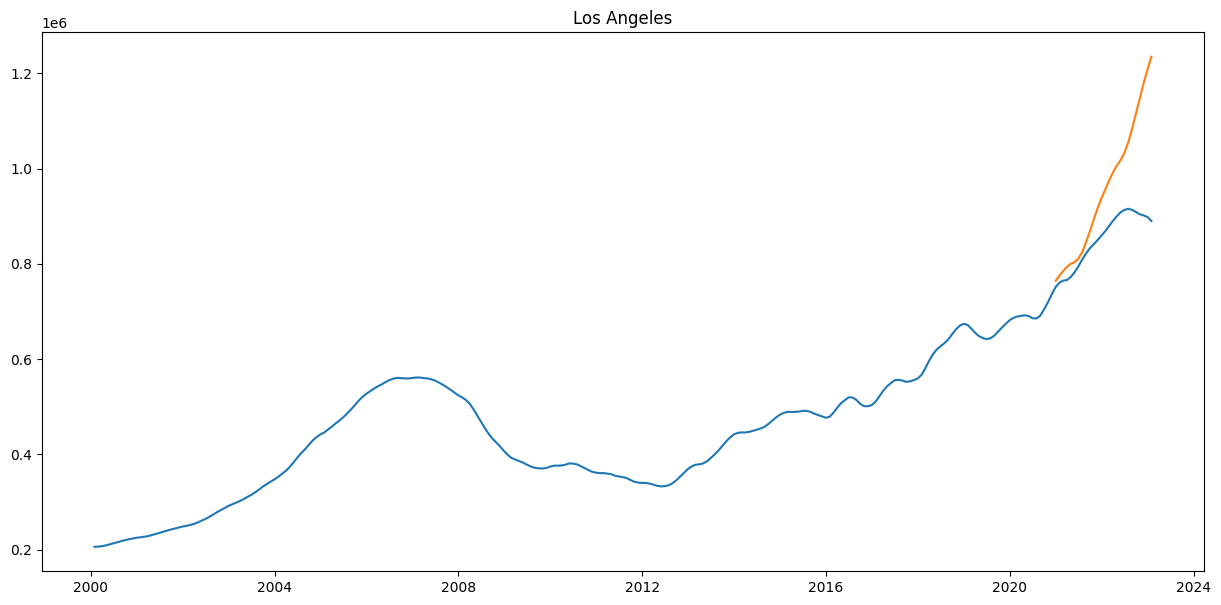

In [ ]:
la_rmse = get_forecast_SARIMAX(zillow_cities_df,'Los Angeles')
sarimax_rmse_values.append(la_rmse)

###San Francisco

City Name:  San Francisco
Test RMSE: 59641.299



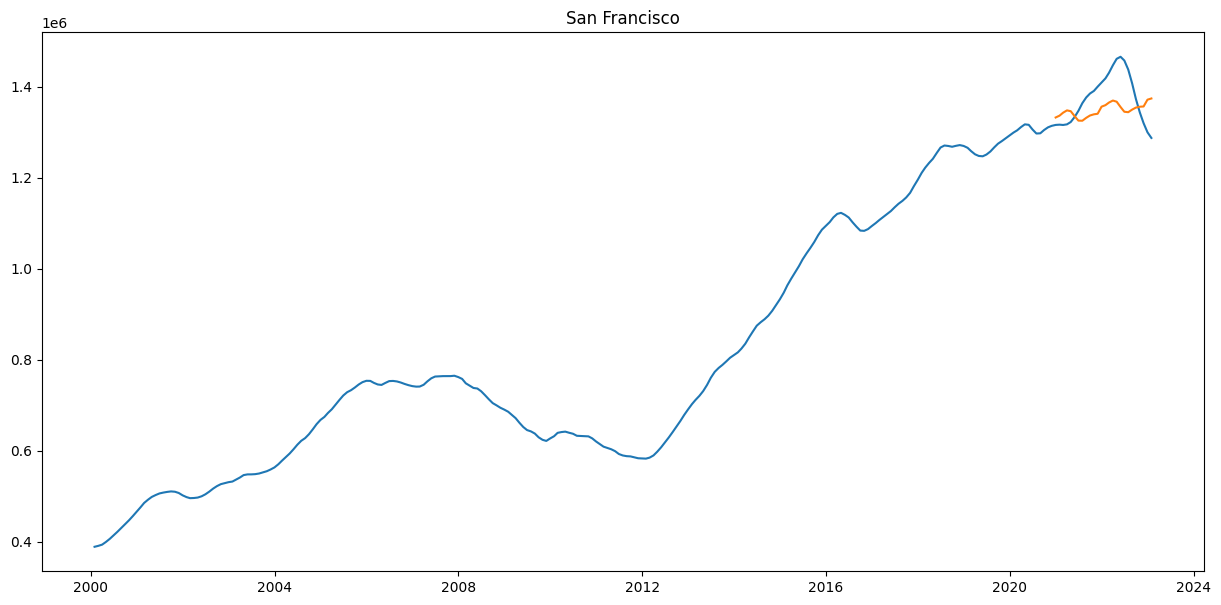

In [ ]:
sf_rmse = get_forecast_SARIMAX(zillow_cities_df,'San Francisco')
sarimax_rmse_values.append(sf_rmse)

###Washington DC

City Name:  Washington
Test RMSE: 72278.170



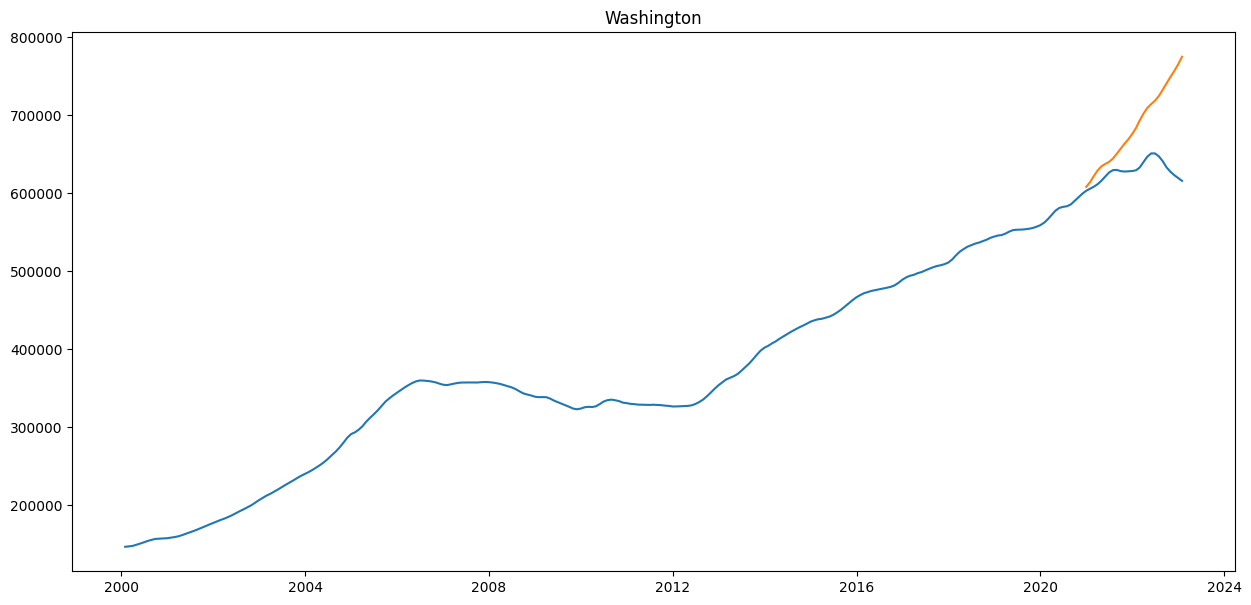

In [ ]:
w_rmse = get_forecast_SARIMAX(zillow_cities_df,'Washington')
sarimax_rmse_values.append(w_rmse)

###Austin

City Name:  Austin
Test RMSE: 72245.114



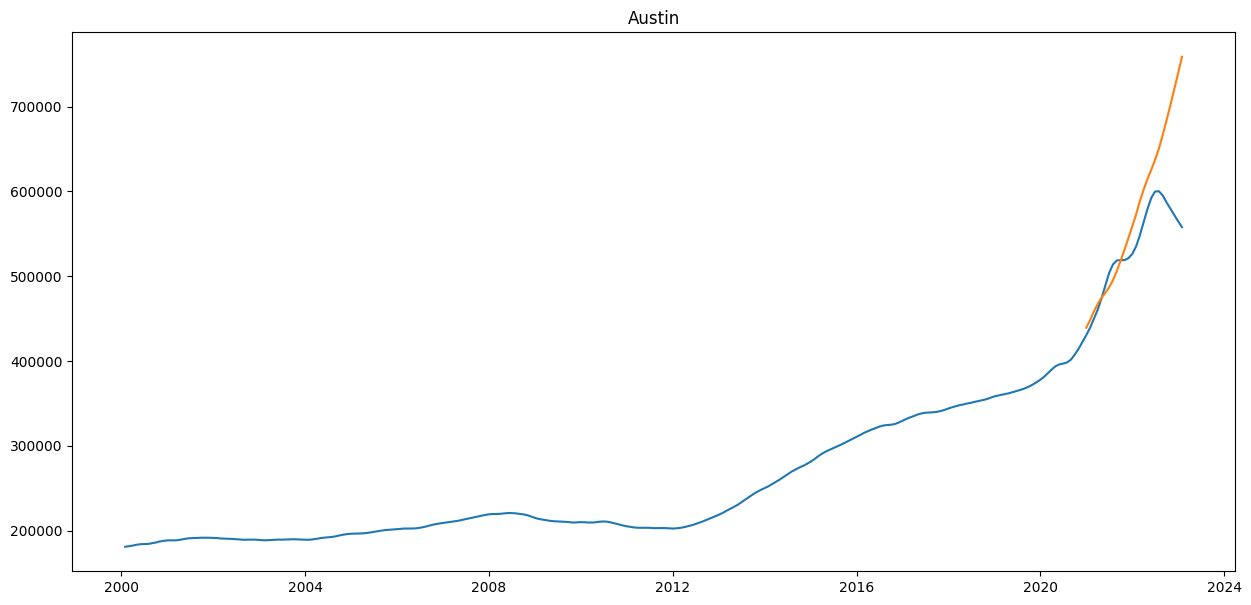

In [ ]:
a_rmse = get_forecast_SARIMAX(zillow_cities_df,'Austin')
sarimax_rmse_values.append(a_rmse)

###Seattle

City Name:  Seattle
Test RMSE: 64496.336



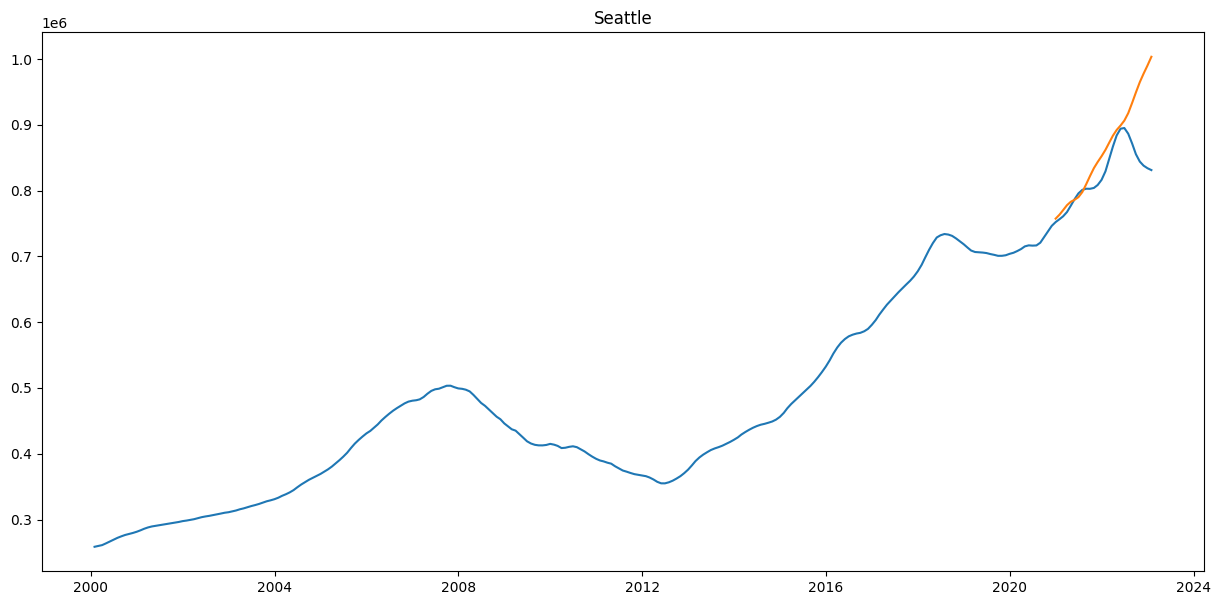

In [ ]:
s_rmse = get_forecast_SARIMAX(zillow_cities_df,'Seattle')
sarimax_rmse_values.append(s_rmse)

##Prophet Modeling and Evaluation

Here, we will perform Prophet modeling on the time series data and plot the forecasted results. Finally, we will also evaluate the predicts of the model using Root Mean Squared Error (RMSE).

In [ ]:
prophet_df = zillow_top_df.drop(columns=['ROI_10years'], axis=0).T
prophet_df.head()

RegionName,New York,Los Angeles,Austin,San Francisco,Seattle,Washington
2000-01-31 00:00:00,130287.519134,205857.114461,181010.892589,388521.878329,258561.719217,146896.463022
2000-02-29 00:00:00,130986.454069,206148.139291,181717.346225,390500.562075,259804.45214,147380.496054
2000-03-31 00:00:00,131695.981347,207040.037608,182383.337418,393215.153069,261096.704771,148048.68133
2000-04-30 00:00:00,133068.080275,208814.686358,183371.857647,399073.492924,263695.11648,149493.215736
2000-05-31 00:00:00,134445.24865,211046.178463,184062.705257,405951.624629,266593.396739,151094.607659


In [ ]:
#Creating a list to store rmse values
prophet_rmse_values = []

In [ ]:
def get_forecast_prophet(df, city_name):
  cols = [x for x in df.index]
    
  values = []
  
  ycol = [x for x in df[city_name]]
  
  # Creating a time series dataframe as per the format required by Prophet
  time_series_df = pd.DataFrame()
  time_series_df['ds'] = cols
  time_series_df['y'] = ycol

  # Creating the train and test sets
  train = time_series_df[(time_series_df['ds'] >= '2013-01-01') &
                         (time_series_df['ds'] <= '2020-12-31')]
  test = time_series_df[time_series_df['ds'] >= '2020-12-31']

  # Set up parameter grid
  param_grid = {  
      'changepoint_prior_scale': [0.05, 0.08, 0.5],
      'seasonality_prior_scale': [1, 5, 10],
      'seasonality_mode': ['additive']
  }
  
  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  
  # Create a list to store RMSE values for each combination
  rmses = [] 
  
  # Use cross validation to evaluate all parameters
  for params in all_params:
      # Fit a model using one parameter combination
      m = proph(**params).fit(train)  
      future_dates = m.make_future_dataframe(periods=25, freq='MS')
      forecast = m.predict(future_dates)
      rmse = np.sqrt(mean_squared_error(test.iloc[:, 1], list(forecast[forecast['ds'] >= '2020-12-31']['yhat'])))
      
      # Save model performance metrics
      rmses.append(rmse)
      
  # Tuning results
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
 
  # Find the best parameters
  best_params = all_params[np.argmin(rmses)]
  print(f'\nBest Params: {best_params}')

  # Fit the model using the best parameters
  model = proph(changepoint_prior_scale=best_params['changepoint_prior_scale'],
  seasonality_prior_scale = best_params['seasonality_prior_scale'],

  # Fit the model on the training dataset
  seasonality_mode = best_params['seasonality_mode'])
  model.fit(train)

  # Making future predictions
  future_dates = model.make_future_dataframe(periods=25, freq='MS')
  forecast = model.predict(future_dates)

  # Calculating RMSE
  new_rmse = np.sqrt(mean_squared_error(test.iloc[:, 1], list(forecast[forecast['ds'] >= '2020-12-31']['yhat'])))

  # Printing the RMSE
  print("City Name:", city_name)
  print('Test RMSE:', new_rmse)

  # Visualizing the predictions
  model.plot(forecast, uncertainty=True)
  plt.title(city_name)
  plt.ylabel('Real Estate Value')
  plt.xlabel('Year')
  model.plot_components(forecast)
  plt.title(city_name)
  plt.ylabel('Real Estate Value')
  plt.xlabel('Yearly Trend');
  
  fig, ax = plt.subplots(figsize=(12, 7))
  plt.plot(time_series_df['ds'],time_series_df['y'])
  plt.plot(forecast[forecast['ds'] >= '2020-12-31']['ds'], 
           list(forecast[forecast['ds'] >= '2020-12-31']['yhat']))
  
  plt.title(city_name)
  plt.legend(['Original','Predicted'], loc='lower right')
  plt.xlabel('Year')
  plt.ylabel('Median Home Price')
  plt.show()
    
  return forecast, new_rmse

###New York

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/cq5cmerv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/pj8ahhgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25519', 'data', 'file=/tmp/tmpn7slb9d5/cq5cmerv.json', 'init=/tmp/tmpn7slb9d5/pj8ahhgl.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_model4b0hl2yo/prophet_model-20230411202808.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


20:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: New York
Test RMSE: 30761.44574834676


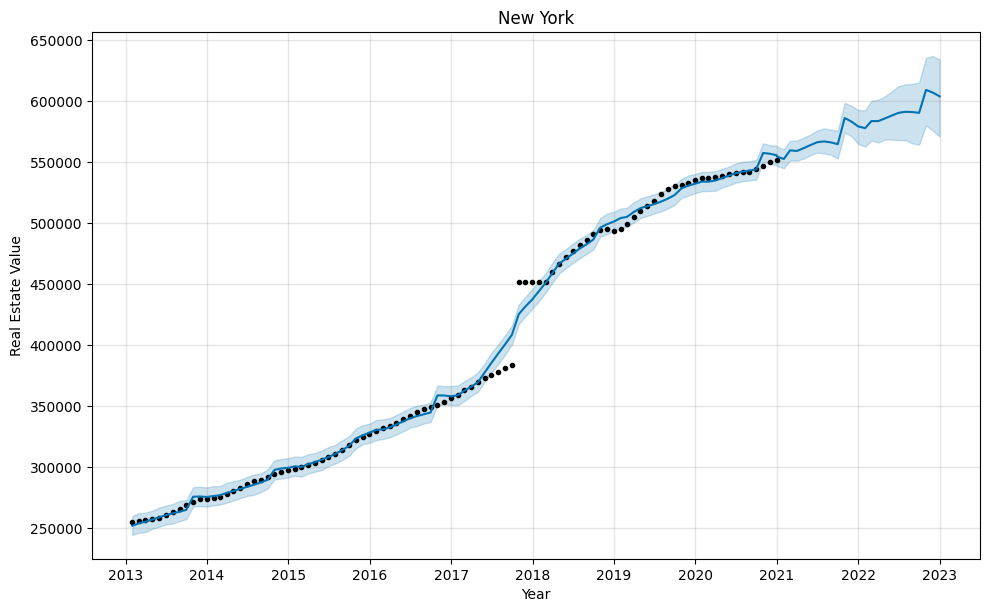

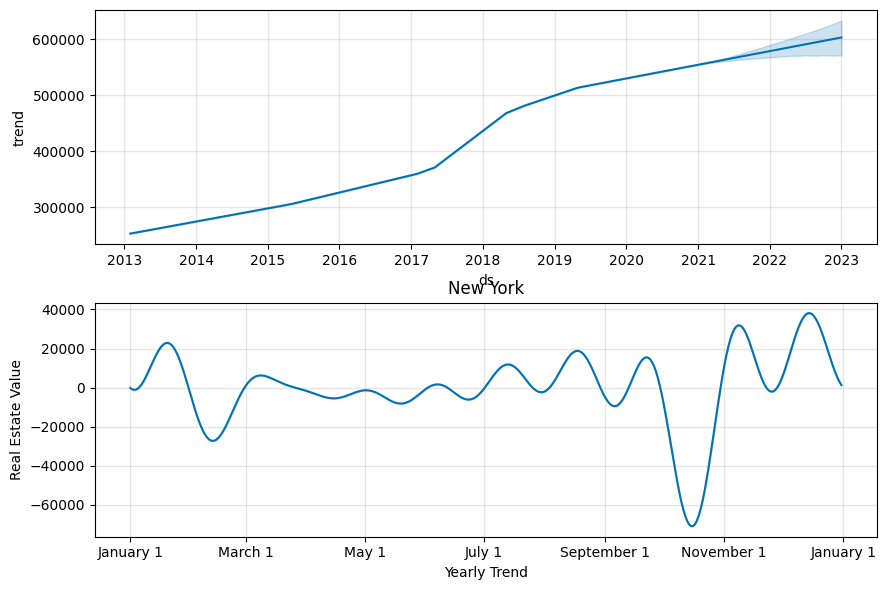

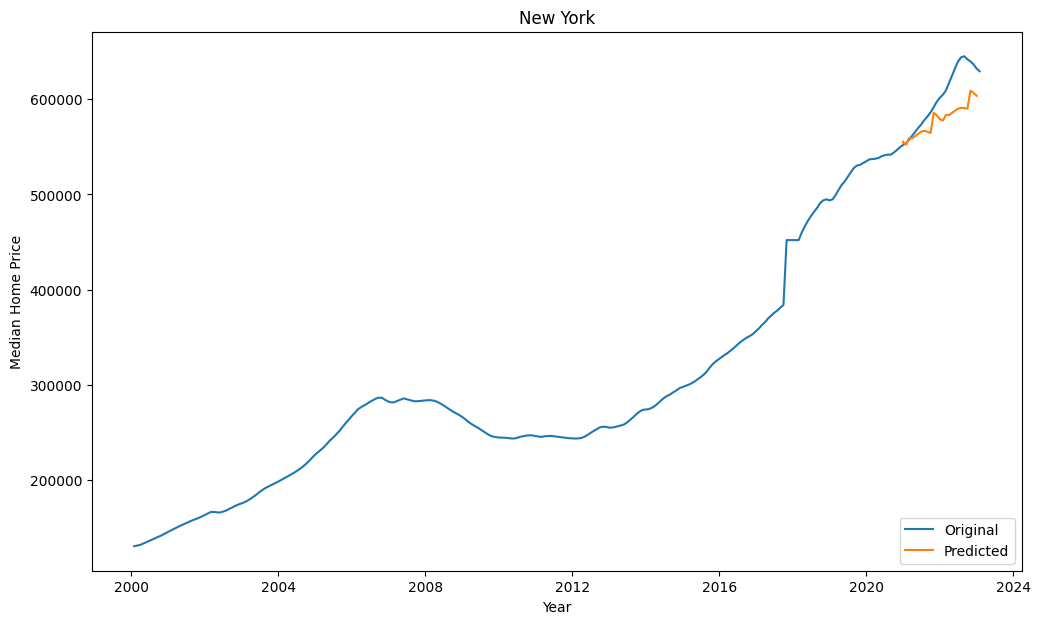

In [ ]:
# new_york_val, new_york_forecast = 
new_york_forecast, ny_rmse = get_forecast_prophet(prophet_df, 'New York')
prophet_rmse_values.append(ny_rmse)

###Los Angeles

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/5b75ox5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/2yjpb0gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89200', 'data', 'file=/tmp/tmpn7slb9d5/5b75ox5k.json', 'init=/tmp/tmpn7slb9d5/2yjpb0gv.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_model6xgpn9a2/prophet_model-20230411202818.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}


20:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: Los Angeles
Test RMSE: 82773.2683130555


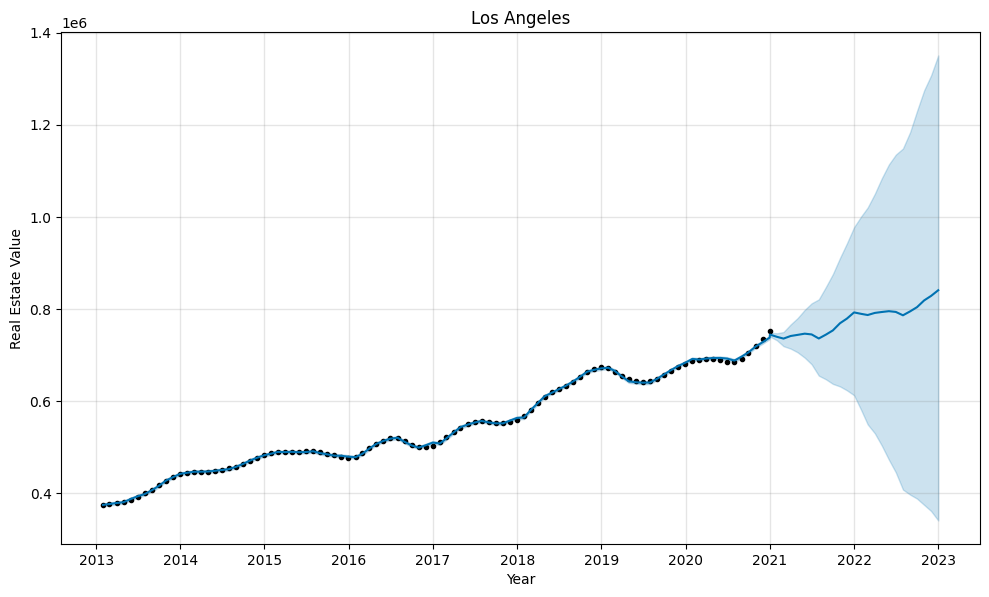

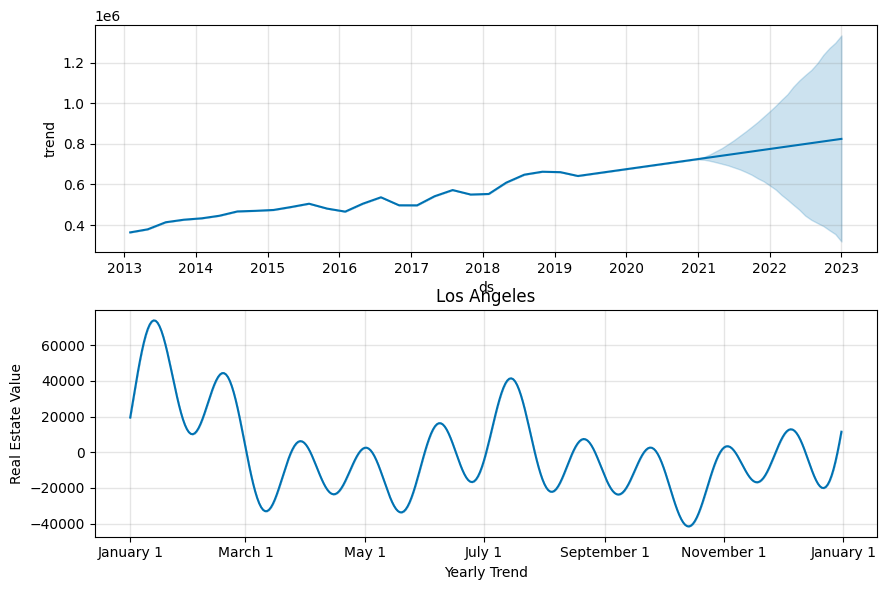

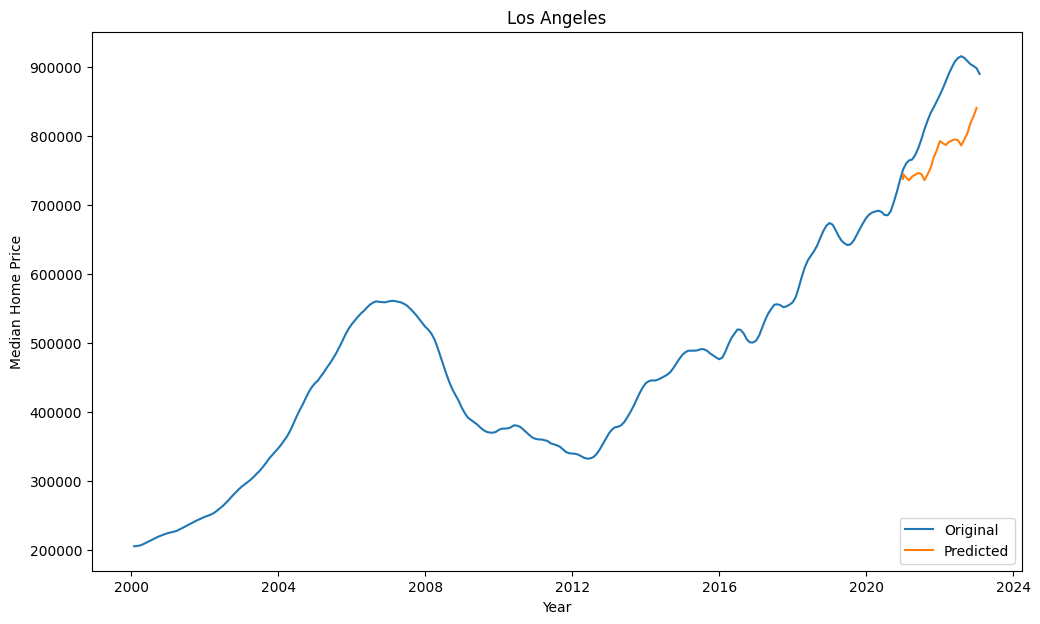

In [ ]:
los_angeles_forecast,la_rmse = get_forecast_prophet(prophet_df, 'Los Angeles')
prophet_rmse_values.append(la_rmse)

###San Francisco

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/2y870c54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/epry3w84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31230', 'data', 'file=/tmp/tmpn7slb9d5/2y870c54.json', 'init=/tmp/tmpn7slb9d5/epry3w84.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_modelanvw881w/prophet_model-20230411202825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


20:28:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: San Francisco
Test RMSE: 54061.05924544124


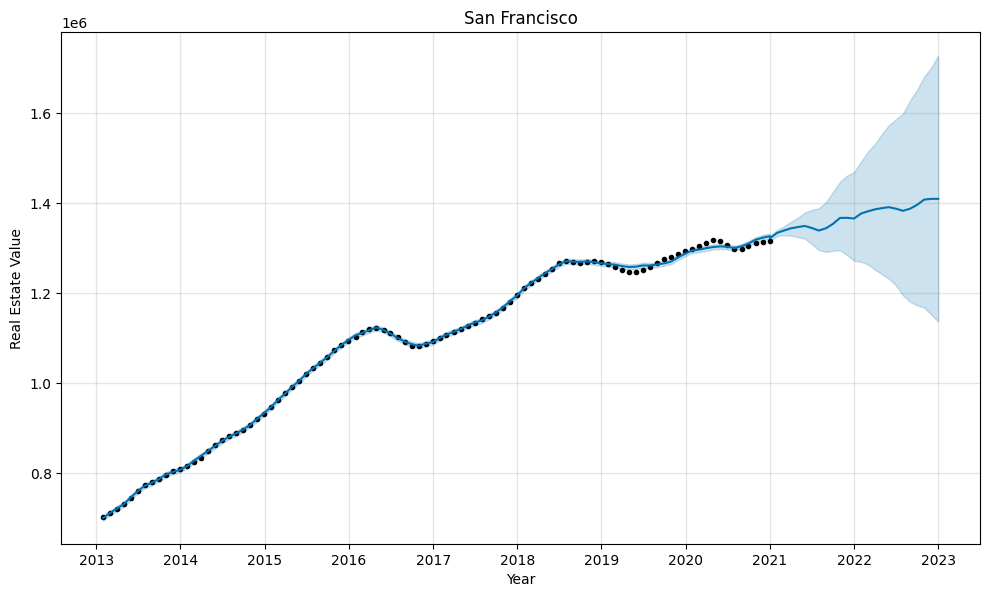

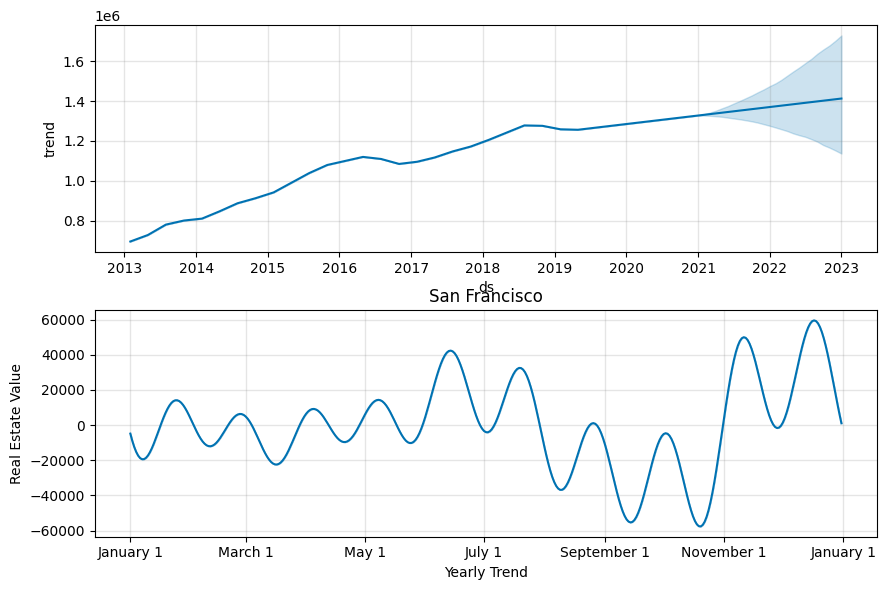

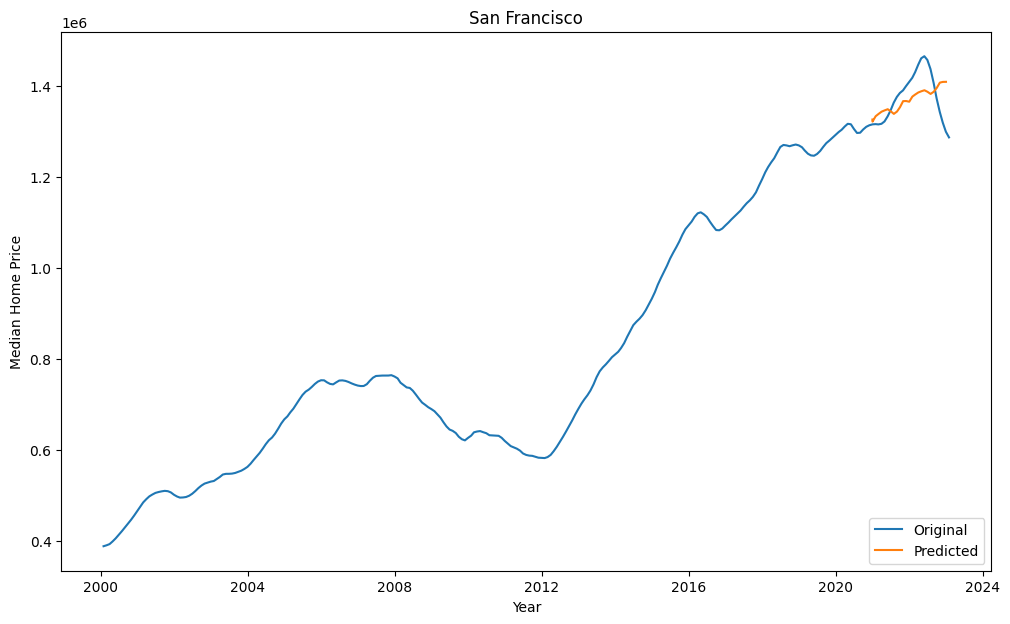

In [ ]:
sf_forecast,sf_rmse = get_forecast_prophet(prophet_df, 'San Francisco')
prophet_rmse_values.append(sf_rmse)

###Washington DC

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/eelt0plx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/pfxkxoax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68655', 'data', 'file=/tmp/tmpn7slb9d5/eelt0plx.json', 'init=/tmp/tmpn7slb9d5/pfxkxoax.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_modelps4_su6p/prophet_model-20230411202832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


20:28:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: Washington
Test RMSE: 16273.95834406776


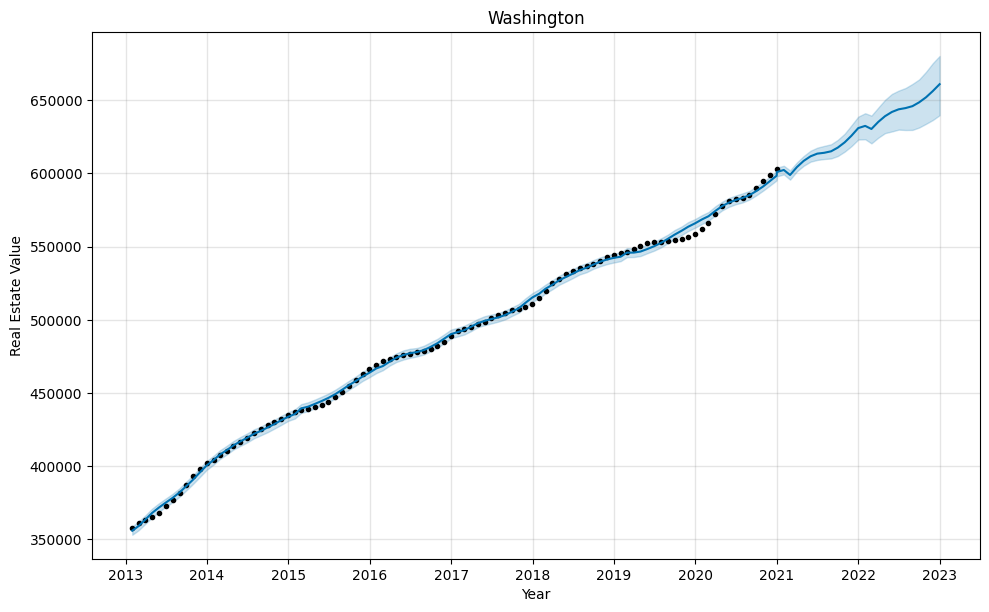

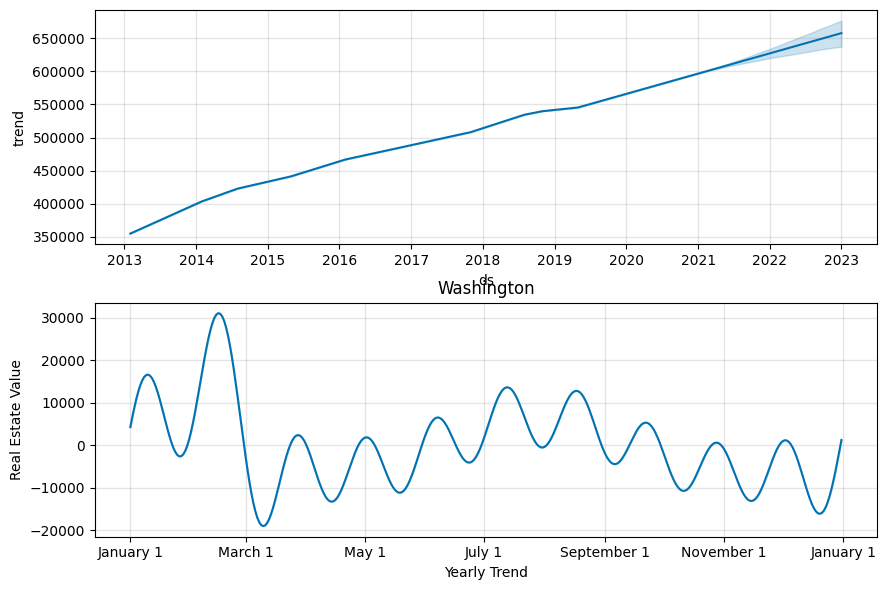

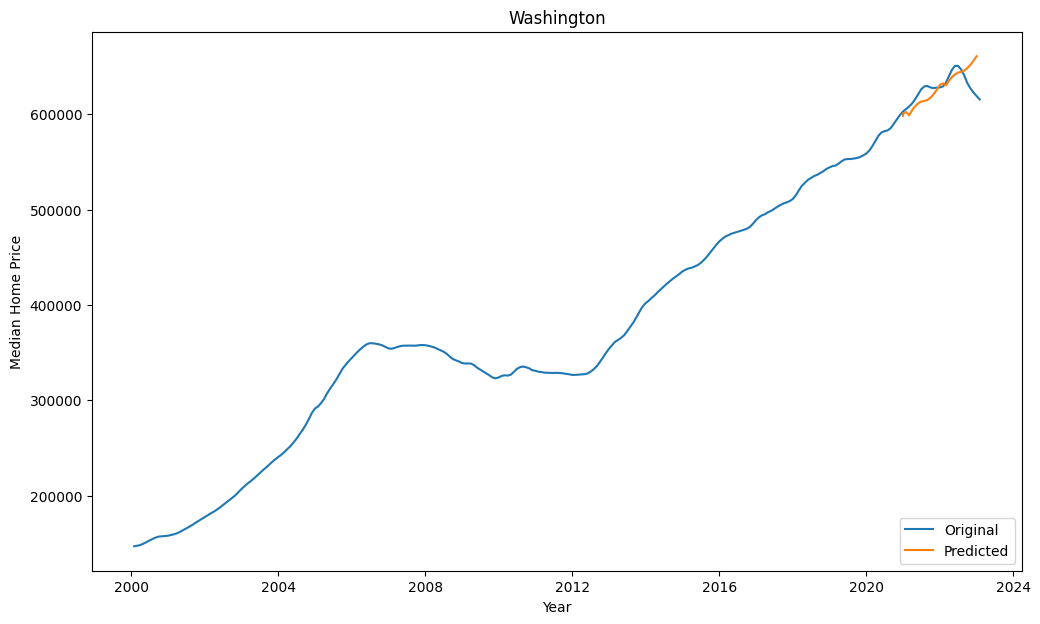

In [ ]:
washington_dc_forecast, w_rmse = get_forecast_prophet(prophet_df, 'Washington')
prophet_rmse_values.append(w_rmse)

###Austin

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/8y8u6i7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/tex84uoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99799', 'data', 'file=/tmp/tmpn7slb9d5/8y8u6i7i.json', 'init=/tmp/tmpn7slb9d5/tex84uoz.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_model16kk3k0s/prophet_model-20230411202839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'seasonality_mode': 'additive'}


20:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: Austin
Test RMSE: 83020.56092386285


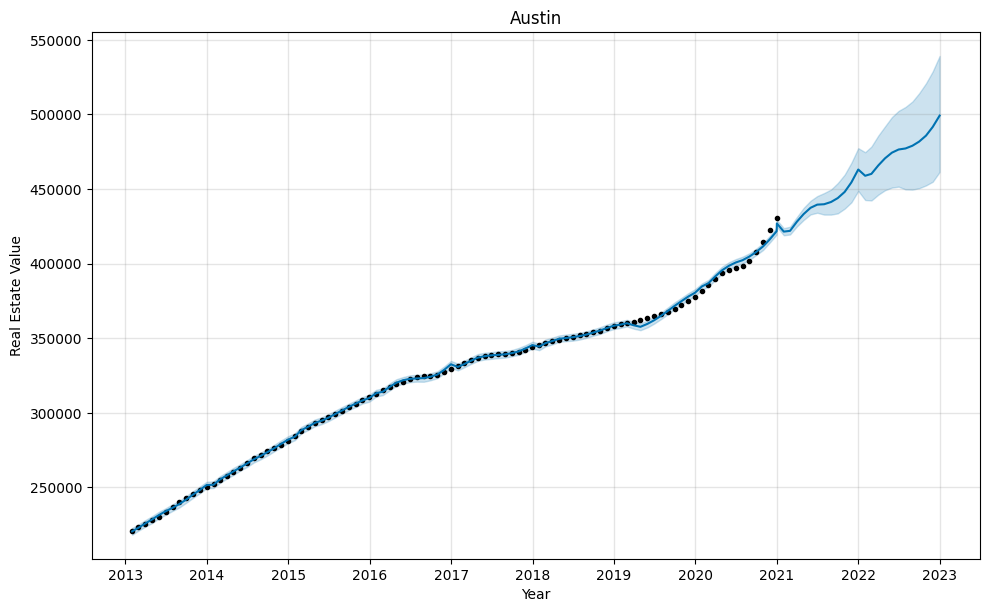

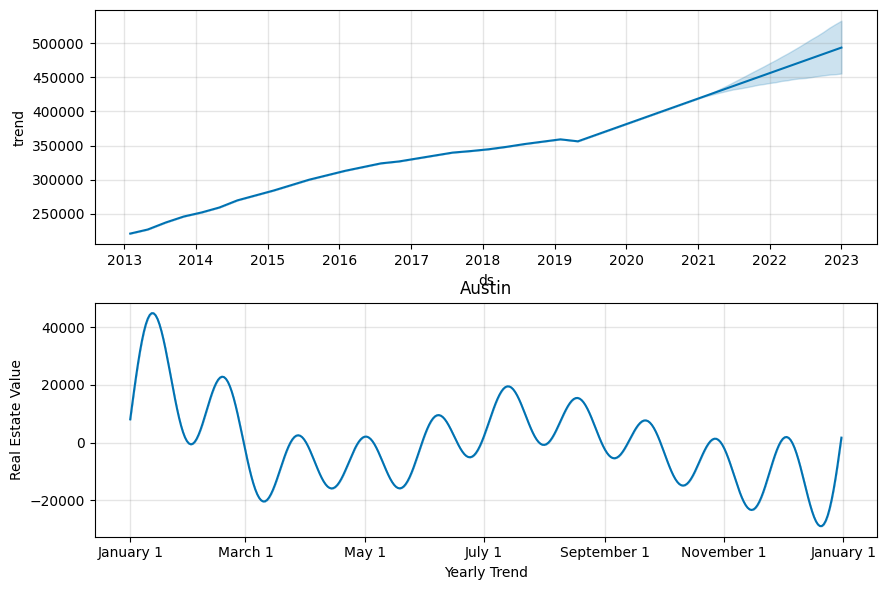

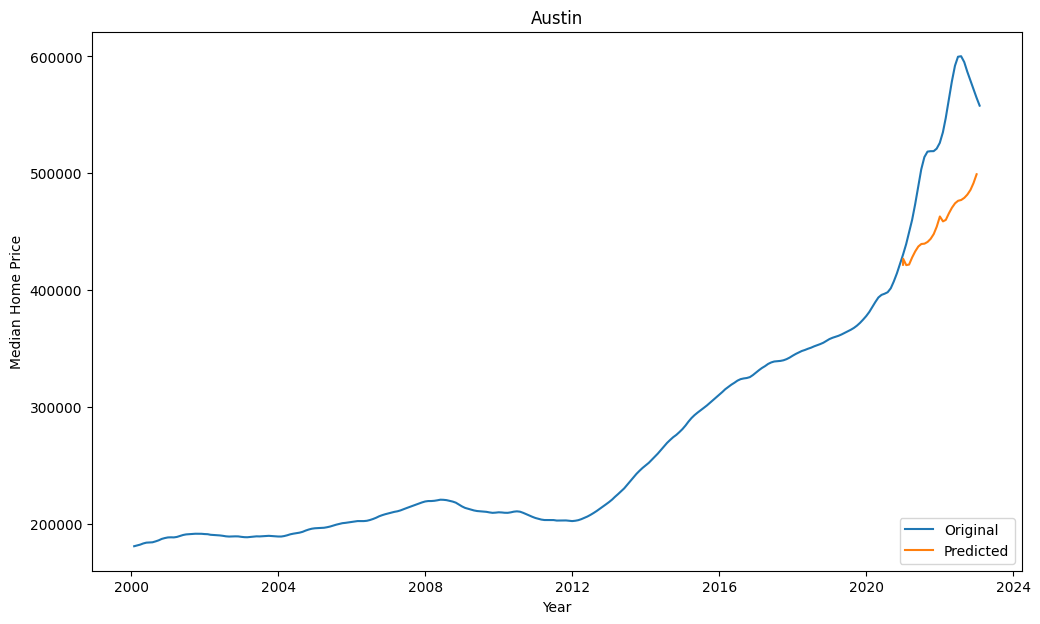

In [ ]:
austin_forecast,a_rmse = get_forecast_prophet(prophet_df, 'Austin')
prophet_rmse_values.append(a_rmse)

###Seattle

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/ja5xjm7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/jl3d0sec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41426', 'data', 'file=/tmp/tmpn7slb9d5/ja5xjm7y.json', 'init=/tmp/tmpn7slb9d5/jl3d0sec.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_modeli_sgli3d/prophet_model-20230411202846.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Best Params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


20:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


City Name: Seattle
Test RMSE: 72058.66139572277


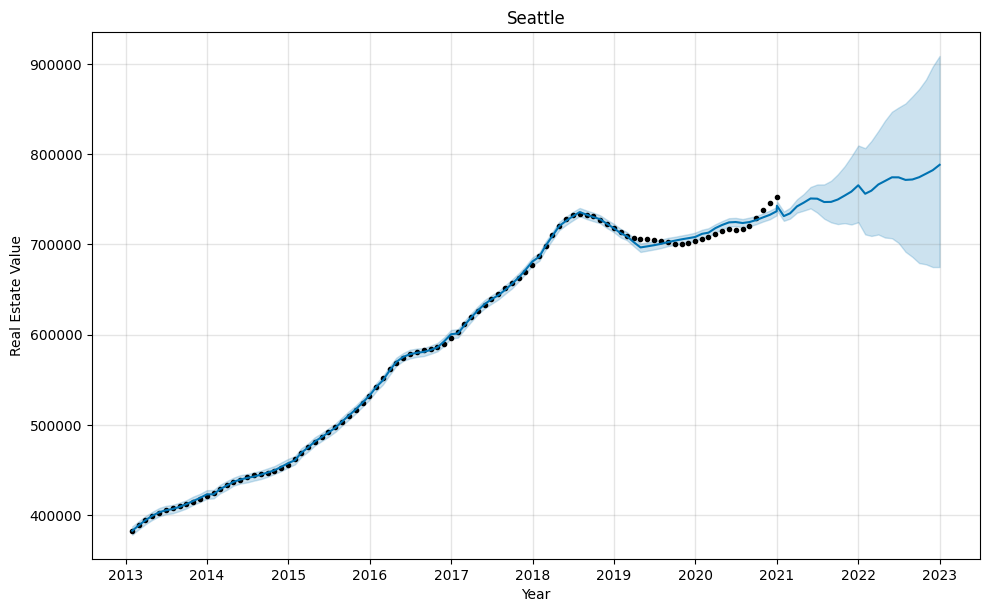

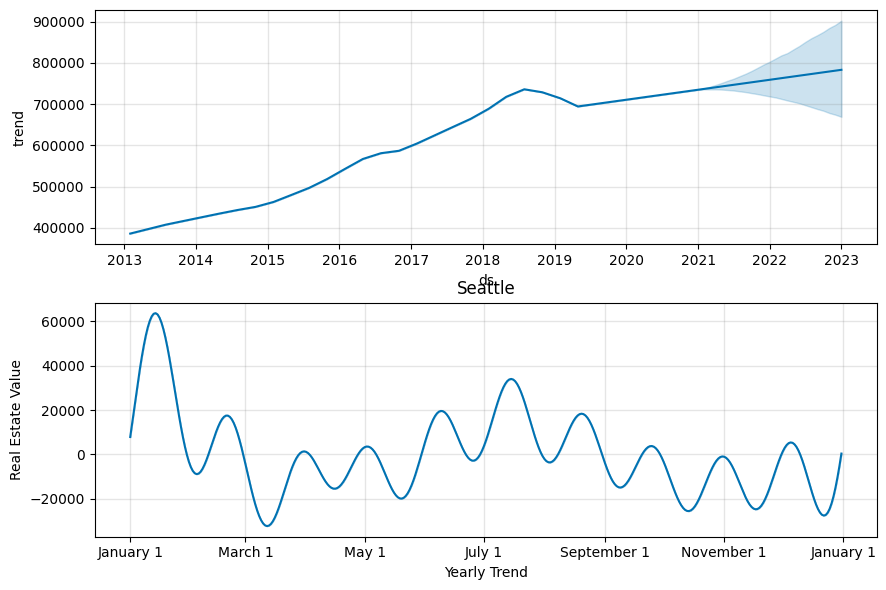

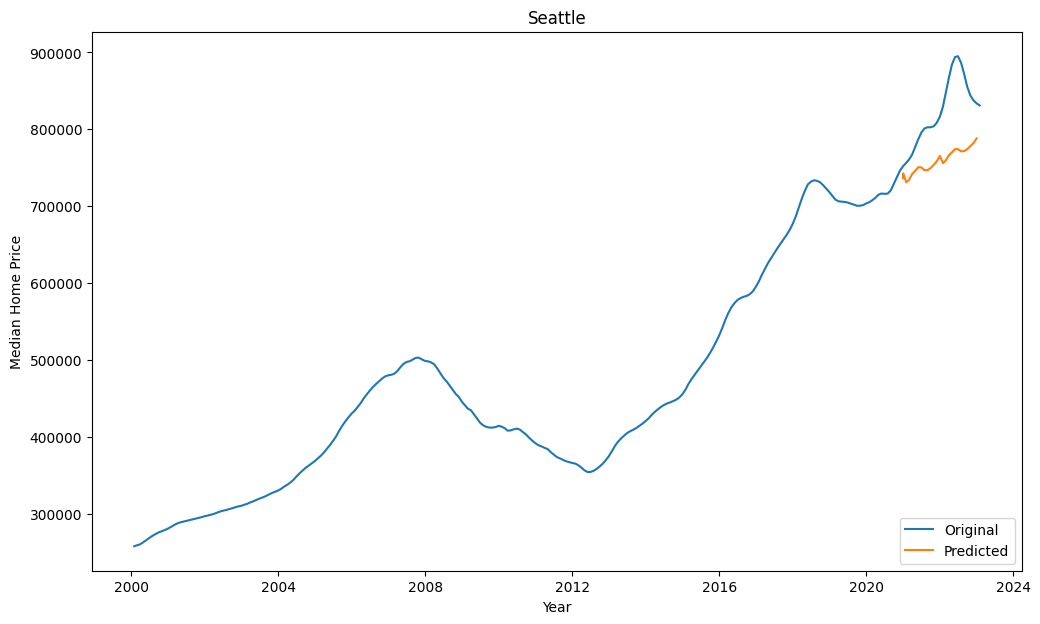

In [ ]:
seattle_forecast,s_rmse = get_forecast_prophet(prophet_df, 'Seattle')
prophet_rmse_values.append(s_rmse)

##Comparison between ARIMA, SARIMAX and Prophet Modelling

We will be plotting the RMSE scores for all 3 models for the given cities: New York, Los Angles, San Franciso, Washington DC, Austin, Seattle

In [ ]:
#Plotting the lists made above
def plot_rmse_values(arima_rmse_values,sarimax_rmse_values,prophet_rmse_values) :
  barWidth = 0.25
  plt.figure(figsize = (12, 7))
  br1 = np.arange(len(arima_rmse_values))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
 
  plt.bar(br1, arima_rmse_values, width = barWidth,
         label ='ARIMA Values')
  plt.bar(br2, sarimax_rmse_values, width = barWidth,
         label ='SARIMAX Values')
  plt.bar(br3,prophet_rmse_values , width = barWidth,
        label ='Prophet Values')
 
  # Adding Xticks
  plt.xlabel('City', fontsize = 15)
  plt.ylabel('RMSE Values', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(arima_rmse_values))],
        ['New York', 'Los Angeles', 'San Francisco', 'Washington DC', 'Austin', 'Seattle'])
 
  plt.legend()
  plt.show()  

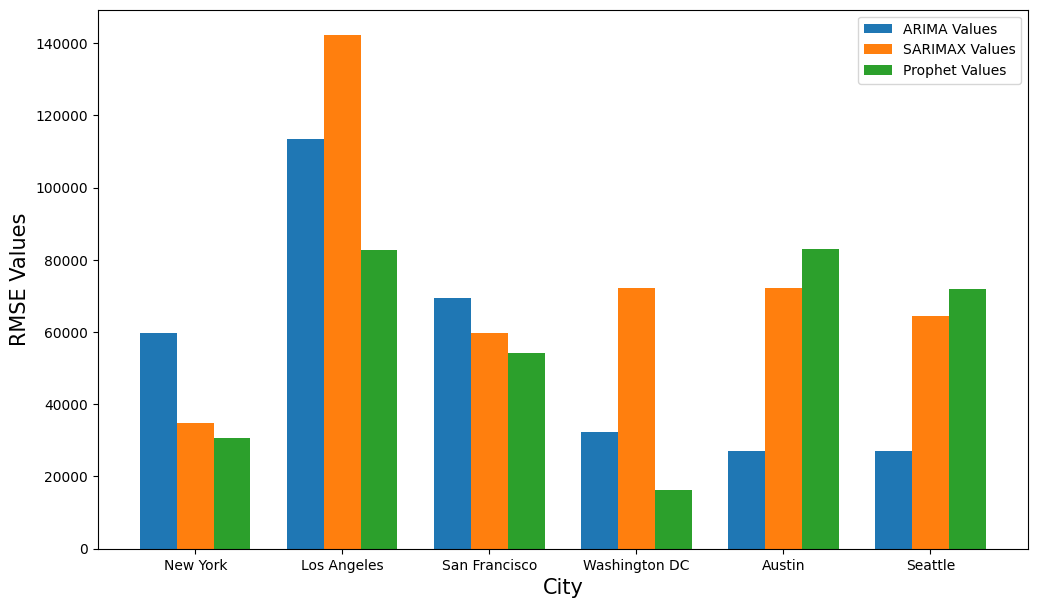

In [ ]:
plot_rmse_values(arima_rmse_values,sarimax_rmse_values,prophet_rmse_values)

##Predicting House Prices for any given city for future

We have created a function where we can pass any city name along with the state code, and get predictions for the House price for next 8 years. We are using the Prophet Model for the same, in this particular function we have used the "Holiday" function of the prophet modelling to specify the sudden drop in the prices from July 2022.

In [ ]:
## Trying to implement handling shocks

def forecast_future_prices(city_name, state_name, all_values_df):
  #Creating a df just for the given city and state
  city_df = all_values_df[((zillow_city.index == city_name) & (zillow_city['State'] == state_name))]

  city_df = drop_columns(city_df)
  city_df.columns = list(convert_datetime(city_df))

  
  #Making changes for Prophet modelling

  cols = [x for x in city_df.columns]
  
  
  ycol = [x for x in city_df.loc[city_name].values]

  # Creating a time series dataframe as per the format required by Prophet
  time_series_df = pd.DataFrame()
  time_series_df['ds'] = cols
  time_series_df['y'] = ycol

  # Creating a dataframe to denote the market crash, which will be sent 
  housing_market_crash = pd.DataFrame([
    {'holiday': 'first_crash', 'ds': '2022-07-31', 'lower_window': 0, 'ds_upper': '2023-04-30'}])
  
  for t_col in ['ds', 'ds_upper']:
    housing_market_crash[t_col] = pd.to_datetime(housing_market_crash[t_col])
  housing_market_crash['upper_window'] = (housing_market_crash['ds_upper'] - housing_market_crash['ds']).dt.days


  model = proph(interval_width=0.90, holidays=housing_market_crash,
                changepoint_prior_scale=0.05)
  model.fit(time_series_df)

  future_dates = model.make_future_dataframe(periods=96, freq='MS')
  forecast = model.predict(future_dates)

  fig, ax = plt.subplots(figsize=(12, 7))
  plt.plot(time_series_df['ds'],time_series_df['y'])
  plt.plot(forecast[forecast['ds'] >= '2022-01-31']['ds'],list(forecast[forecast['ds'] >= '2022-01-31']['yhat']))
  
  plt.title(city_name)
  plt.legend(['Original Price','Predicted Future Values'], loc='lower right')
  plt.xlabel('Year')
  plt.ylabel('Median Home Price')
  plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/9j77kc0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7slb9d5/vl7s2dym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17449', 'data', 'file=/tmp/tmpn7slb9d5/9j77kc0j.json', 'init=/tmp/tmpn7slb9d5/vl7s2dym.json', 'output', 'file=/tmp/tmpn7slb9d5/prophet_model0wn41hf1/prophet_model-20230411202854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


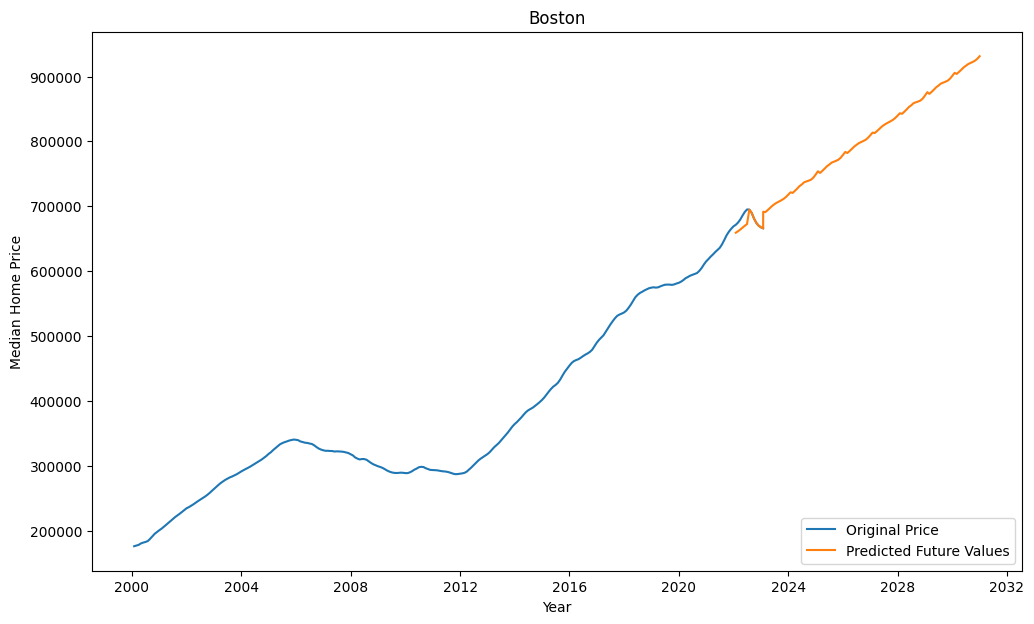

In [ ]:
# Calling the function forecast_future_prices
forecast_future_prices('Boston', 'MA', zillow_city)